
<br>
<font>
<div dir=ltr align=center>
<font color=0F5298 size=7>
    System 2 - Homework 1<br>
<font color=2565AE size=5>
    Spring 2025<br>
<font color=3C99D size=5>
    Symbolic Regression <br>


---

### Student Number = 99102286

### Full Name = Benyamin Maleki

---

# Introduction

This notebook explores two methods for performing symbolic regression, focusing on both traditional and modern AI-driven approaches:

## 1. EQL-Based Symbolic Regression  
The first approach we implement is based on **Equation Learner (EQL)**, a neural network-based symbolic regression technique. EQL leverages neural networks with activation functions that encourage the discovery of symbolic expressions, making it a differentiable and trainable approach for learning equations directly from data. This method helps in bridging the gap between deep learning and symbolic reasoning.

## 2. Seq2Seq-Based Symbolic Regression with Transformers
A more recent and powerful approach to symbolic regression leverages Sequence-to-Sequence (Seq2Seq) models using Transformers. In this method, we frame symbolic regression as a translation problem, where the input consists of numerical data points and the output is a corresponding mathematical expression. By training a Transformer model on pairs of input data and symbolic expressions, we can enable it to generalize and infer underlying symbolic patterns. This approach benefits from the self-attention mechanism, allowing it to capture long-range dependencies in mathematical structures effectively.


# Datasets

We use two datasets to evaluate our methods:

- **Dataset 1:** This dataset is provided in the notebook, and its underlying mathematical formula is explicitly given. It serves as a reference to assess the performance of different symbolic regression approaches. The expression we consider is: `2 * x + np.sin(x) + x * np.sin(x)`.
  
- **Dataset 2:** This dataset is also provided with the notebook, but its underlying mathematical relationship is hidden. Throughout different parts of the notebook, you will attempt to uncover the equation governing this dataset. Your responses will be evaluated based on how accurately you recover the true formula.

By working through both datasets, we aim to test the robustness and accuracy of various symbolic regression techniques while providing an engaging and exploratory learning experience.

# Import Libraries

In [1]:
import pickle
import numpy as np
import sympy as sp
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from inspect import signature
import time
from tqdm.auto import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sympy
import glob
import time
import signal
import random
import warnings
import json
import re

warnings.filterwarnings('ignore')

# Generate Dataset

In [2]:
def generate_data(func, N, range_min=-2, range_max=2, noise_std=0.1):
    """
    Generates a dataset by evaluating the given function on random input values with added noise.

    Parameters:
    func (callable): A function that takes numerical inputs and returns a scalar output.
    N (int): The number of data points to generate.
    range_min (float, optional): The minimum value of the input range. Default is -2.
    range_max (float, optional): The maximum value of the input range. Default is 2.
    noise_std (float, optional): Standard deviation of Gaussian noise added to function outputs. Default is 0.1.

    Returns:
    tuple: A tuple (x, y) where:
        - x (torch.Tensor): A tensor of shape (N, x_dim), where x_dim is the number of inputs to func.
        - y (torch.Tensor): A tensor of shape (N, 1) containing the noisy function outputs.
    """

    x_dim = len(signature(func).parameters)  # Number of inputs to the function
    x = (range_max - range_min) * torch.rand([N, x_dim]) + range_min
    y = torch.tensor([[func(*x_i)] for x_i in x], dtype=torch.float32)

    # Adding Gaussian noise
    noise = torch.randn(y.shape) * noise_std
    y_noisy = y + noise

    return x, y_noisy

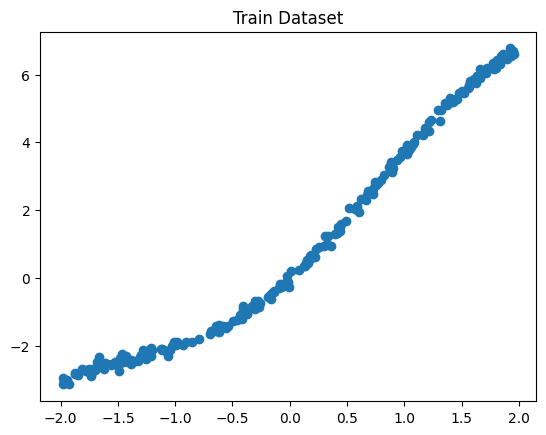

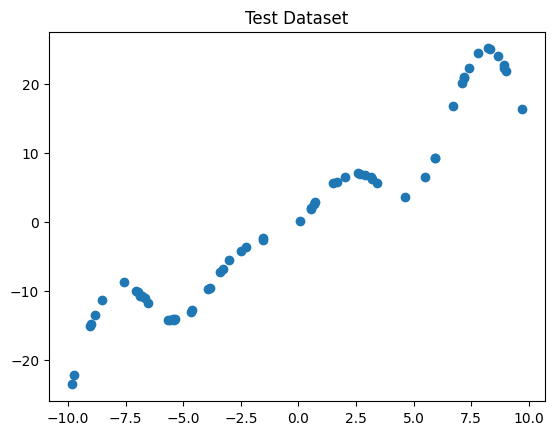

In [3]:
# Define train and test first dataset

x_train, y_train = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 240, -2, 2)
plt.scatter(x_train, y_train)
plt.title('Train Dataset')
plt.show()

# We change range_min and range_max here to test its OOD (out-of-distribution) performance

x_test, y_test = generate_data(lambda x: 2 * x + np.sin(x) + x * np.sin(x), 60, -10, 10)
plt.scatter(x_test, y_test)
plt.title('Test Dataset')
plt.show()

# EQL

Equation Learner (EQL) is a neural network-based approach to symbolic regression that discovers mathematical expressions directly from data. Unlike traditional deep learning models that treat regression as a black-box approximation, EQL is designed to output interpretable symbolic expressions. EQL uses a special type of neural network where activation functions are not just standard non-linearities (like ReLU or sigmoid) but include mathematical operations such as addition, multiplication, and trigonometric functions (e.g., sin(x), cos(x)).

<p align="center">
  <img style="margin-top: 30px" src="https://camo.githubusercontent.com/f4722b552bd6d4bd3909ff054ebef8bc4a973d9dd93e2ccacd6c77f4e03e3443/68747470733a2f2f692e696d6775722e636f6d2f485a58776656492e706e67" width="1000">
</p>

### Retrieve expressions

This cell is used to retrieve expressions from the network. Do not modify this cell.

In [4]:
# DON'T CHNAGE THIS CELL

"""
Generate a mathematical expression for the symbolic regression get_expression (also known as the EQL network) using SymPy.
This expression can be utilized for pretty-printing in various formats, including human-readable text and LaTeX.
Additionally, SymPy enables algebraic manipulation of the expression.
"""


def apply_activation(W, funcs, n_double=0):
    """Given an (n, m) matrix W and (m) vector of funcs, apply funcs to W.

    Arguments:
        W:  (n, m) matrix
        funcs: list of activation functions (SymPy functions)
        n_double:   Number of activation functions that take in 2 inputs

    Returns:
        SymPy matrix with 1 column that represents the output of applying the activation functions.
    """
    W = sp.Matrix(W)
    if n_double == 0:
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                W[i, j] = funcs[j](W[i, j])
    else:
        W_new = W.copy()
        out_size = len(funcs)
        for i in range(W.shape[0]):
            in_j = 0
            out_j = 0
            while out_j < out_size - n_double:
                W_new[i, out_j] = funcs[out_j](W[i, in_j])
                in_j += 1
                out_j += 1
            while out_j < out_size:
                W_new[i, out_j] = funcs[out_j](W[i, in_j], W[i, in_j+1])
                in_j += 2
                out_j += 1
        for i in range(n_double):
            W_new.col_del(-1)
        W = W_new
    return W


def sym_pp(W_list, funcs, var_names, threshold=0.01, n_double=0):
    """Pretty print the hidden layers (not the last layer) of the symbolic regression network

    Arguments:
        W_list: list of weight matrices for the hidden layers
        funcs:  list of lambda functions using sympy. has the same size as W_list[i][j, :]
        var_names: list of strings for names of variables
        threshold: threshold for filtering expression. set to 0 for no filtering.
        n_double:   Number of activation functions that take in 2 inputs

    Returns:
        Simplified sympy expression.
    """
    vars = []
    for var in var_names:
        if isinstance(var, str):
            vars.append(sp.Symbol(var))
        else:
            vars.append(var)
    expr = sp.Matrix(vars).T
    # W_list = np.asarray(W_list)
    for W in W_list:
        W = filter_mat(sp.Matrix(W), threshold=threshold)
        expr = expr * W
        expr = apply_activation(expr, funcs, n_double=n_double)
    # expr = expr * W_list[-1]
    return expr


def last_pp(eq, W):
    """Pretty print the last layer."""
    return eq * filter_mat(sp.Matrix(W))


def count_inputs(funcs):
    i = 0
    for func in funcs:
        if isinstance(func, BaseFunction):
            i += 1
        elif isinstance(func, BaseFunction2):
            i += 2
    return i


def count_double(funcs):
    i = 0
    for func in funcs:
        if isinstance(func, BaseFunction2):
            i += 1
    return i


def get_expression(weights, funcs, var_names, threshold=0.01):
    """Pretty print the entire symbolic regression network.

    Arguments:
        weights: list of weight matrices for the entire network
        funcs:  list of lambda functions using sympy. has the same size as W_list[i][j, :]
        var_names: list of strings for names of variables
        threshold: threshold for filtering expression. set to 0 for no filtering.

    Returns:
        Simplified sympy expression."""
    n_double = count_double(funcs)
    funcs = [func.sp for func in funcs]

    expr = sym_pp(weights[:-1], funcs, var_names, threshold=threshold, n_double=n_double)
    expr = last_pp(expr, weights[-1])
    expr = expr[0, 0]
    return expr


def filter_mat(mat, threshold=0.01):
    """Remove elements of a matrix below a threshold."""
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            if abs(mat[i, j]) < threshold:
                mat[i, j] = 0
    return mat


def filter_expr(expr, threshold=0.01):
    expr_new = sp.Integer(0)
    for arg in expr.args:
        if arg.is_constant() and abs(arg) > threshold:   # hack way to check if it's a number
            expr_new = expr_new + arg
        elif not arg.is_constant() and abs(arg.args[0]) > threshold:
            expr_new = expr_new + arg
    return expr_new


def filter_expr2(expr, threshold=0.01):
    for a in sp.preorder_traversal(expr):
        if isinstance(a, sp.Float) and a < threshold:
            expr = expr.subs(a, 0)
    return expr

### Base Functions
These cells contain functions for use in symbolic regression. Each function encapsulates multiple implementations (SymPy, Torch) of a particular operation, allowing them to be used in different contexts. You need to complete the Torch sections.

In [5]:
# Complete TODO parts

"""Functions for use with symbolic regression.

These functions encapsulate multiple implementations (sympy, torch) of a particular function so that the
functions can be used in multiple contexts."""

class BaseFunction:
    """Abstract class for primitive functions"""
    def __init__(self, norm=1):
        self.norm = norm

    def sp(self, x):
        """Sympy implementation"""
        return None

    def torch(self, x):
        """No need for base function"""
        return None

    def name(self, x):
        return str(self.sp)


class Constant(BaseFunction):
    def torch(self, x):
        return torch.ones_like(x)

    def sp(self, x):
        return 1


class Identity(BaseFunction):
    """
    A function class that applies an identity transformation with normalization.

    Attributes:
    norm (float): A normalization factor that scales the input.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the identity transformation by dividing the input by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the identity function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The normalized output tensor.

        """
        # ================ TODO ================
        return x / self.norm
        # ======================================
    def sp(self, x):
        return x / self.norm



class Square(BaseFunction):
    """
    A function class that applies a squared transformation with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Returns the squared value of the input, divided by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the squared function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The squared output tensor divided by the normalization factor.
        """
        # ================ TODO ================
        return torch.pow(x, 2) / self.norm
        # ======================================
        

    def sp(self, x):
        return x ** 2 / self.norm


class Pow(BaseFunction):
    """
    A function class that raises the input to a given power and normalizes the result.

    Attributes:
    power (float): The exponent to which the input is raised.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Raises the input to the specified power and divides by the normalization factor.
    """

    def __init__(self, power: float, norm: float = 1):
        """
        Initializes the Pow function with a given exponent and normalization factor.

        Parameters:
        power (float): The exponent for the power function.
        norm (float, optional): The normalization factor. Default is 1.
        """
        
        BaseFunction.__init__(self, norm=norm)
        self.power = power

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the power function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The output tensor, where each element is raised to the given power and normalized.
        """
        # ================ TODO ================
        return torch.pow(x, self.power) / self.norm
        # ======================================
        

    def sp(self, x):
        return x ** self.power / self.norm

class Sin(BaseFunction):
    """
    A function class that applies a sine transformation with frequency scaling and normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies a sine transformation to the input and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the sine function with frequency scaling and normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The sine-transformed tensor divided by the normalization factor.
        """

        # ================ TODO ================
        return torch.sin(x * 4 * np.pi) / self.norm
        # ======================================
        

    def sp(self, x):
        return sp.sin(x * 2*2*np.pi) / self.norm


class Sigmoid(BaseFunction):
    """
    A function class that applies the sigmoid function with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the sigmoid function and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the sigmoid function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The sigmoid-transformed tensor divided by the normalization factor.
        """

        # ================ TODO ================
        return torch.sigmoid(20 * x) / self.norm
        # ======================================


    def sp(self, x):
        return 1 / (1 + sp.exp(-20*x)) / self.norm

    def name(self, x):
        return "sigmoid(x)"


class Exp(BaseFunction):
    """
    A function class that applies an exponential transformation with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the exponential function (subtracting 1) and divides by the normalization factor.
    """

    def __init__(self, norm: float = np.e):
        """
        Initializes the Exp function with a normalization factor.

        Parameters:
        norm (float, optional): The normalization factor. Default is Euler's number (e).
        """
        super().__init__(norm)

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the modified exponential function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The transformed tensor, where exp(x) - 1 is computed and divided by the normalization factor.
        """

        # ================ TODO ================
        return (torch.exp(x) - 1) / self.norm
        # ======================================

    def sp(self, x):
        return (sp.exp(x) - 1) / self.norm


class Log(BaseFunction):
    """
    A function class that applies the logarithm function with normalization.

    Methods:
    torch(x: torch.Tensor) -> torch.Tensor:
        Applies the logarithm function (on the absolute value of input) and divides by the normalization factor.
    """

    def torch(self, x: torch.Tensor) -> torch.Tensor:
        """
        Applies the logarithm function with normalization.

        Parameters:
        x (torch.Tensor): The input tensor.

        Returns:
        torch.Tensor: The log-transformed tensor divided by the normalization factor.
        """

        # ================ TODO ================
        return torch.log(torch.abs(x) + 1e-8) / self.norm # Add a small epsilon for numerical stability
        # ======================================
        
    def sp(self, x):
        return sp.log(sp.Abs(x)) / self.norm


class BaseFunction2:
    """Abstract class for primitive functions with 2 inputs"""
    def __init__(self, norm=1.):
        self.norm = norm

    def sp(self, x, y):
        """Sympy implementation"""
        return None

    def torch(self, x, y):
        return None

    def name(self, x, y):
        return str(self.sp)


class Product(BaseFunction2):
    """
    A function class that computes the product of two inputs with normalization.

    Methods:
    torch(x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        Computes the product of two input tensors and divides by the normalization factor.
    """

    def __init__(self, norm: float = 0.1):
        """
        Initializes the Product function with a normalization factor.

        Parameters:
        norm (float, optional): The normalization factor. Default is 0.1.
        """
        super().__init__(norm=norm)

    def torch(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """
        Computes the product of two input tensors with normalization.

        Parameters:
        x (torch.Tensor): The first input tensor.
        y (torch.Tensor): The second input tensor.

        Returns:
        torch.Tensor: The element-wise product of x and y, divided by the normalization factor.
        """

        # ================ TODO ================
        return torch.mul(x, y) / self.norm
        # ======================================

    def sp(self, x, y):
        return x * y / self.norm



### Model Architecture

In this section, we define the architecture of the symbolic regression neural network using the Equation Learner (EQL) approach. The model is designed to learn mathematical expressions by incorporating activation functions that correspond to primitive mathematical operations.

1. SymbolicLayer: Each layer applies a set of predefined functions (e.g., sin(x), cos(x), x^2, etc.). The weight matrix determines how input features are transformed and combined. Functions are applied either as single-input (f(x)) or double-input (f(x, y)) operations.

2. SymbolicNet: Composed of multiple SymbolicLayer instances. Uses trainable weight matrices to learn meaningful expressions. The final layer outputs a weighted sum without an activation function.

In [6]:
"""Contains the symbolic regression neural network architecture."""
import numpy as np
import torch
import torch.nn as nn

def count_double(funcs):
    return sum(isinstance(f, BaseFunction2) for f in funcs)

def count_inputs(funcs):
    singles = sum(isinstance(f, BaseFunction) for f in funcs)
    doubles = count_double(funcs)
    return singles + 2 * doubles

class SymbolicLayer(nn.Module):
    """Neural network layer for symbolic regression where activation functions correspond to primitive functions.
    Can take multi-input activation functions (like multiplication)"""
    def __init__(self, funcs, initial_weight=None, init_stddev=0.1, in_dim=None):
        """
        funcs: List of activation functions, using utils.functions
        initial_weight: (Optional) Initial value for weight matrix
        variable: Boolean of whether initial_weight is a variable or not
        init_stddev: (Optional) if initial_weight isn't passed in, this is standard deviation of initial weight

        Parameters need to define:

        - self.W: The weight matrix of the layer. It maps the input features to the output functions. If an `initial_weight` is provided, it is used as the initial weight matrix. 
                  Otherwise, it is initialized from a normal distribution with mean 0 and standard deviation `init_stddev`.
        """

        # This structure of this network is just a suggested. If you want you can make a different network but it should implement EQL.

        super().__init__()

        self.funcs_cfg = funcs  # keep the original objects (we need them for count_* helpers)
        self.funcs = [f.torch for f in funcs]
        self.n_funcs = len(funcs)
        self.n_double = count_double(funcs)
        self.n_single = self.n_funcs - self.n_double
        # weight matrix requires one column per single‑input op and two per double‑input op
        self.out_dim = self.n_single + 2 * self.n_double


        # Define and initialize the weight matrix `W`.
        # If `initial_weight` is provided, use it; otherwise, initialize with a normal distribution.
        
        # =================================== TODO ===================================
        if initial_weight is not None:
            W_init = torch.as_tensor(initial_weight, dtype=torch.float32)
        else:
            W_init = torch.randn(in_dim, self.out_dim) * init_stddev
        self.W = nn.Parameter(W_init)
        # ============================================================================

    def forward(self, x):

        """
        Computes the forward pass of the layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_dim).

        Returns:
            torch.Tensor: Output tensor after applying the symbolic functions.

        Process:
            1. Multiply input `x` with weight matrix `W` to get weighted sum `g`.
            2. Apply the activation functions:
               - Single-input functions take one element from `g`.
               - Two-input functions take two elements from `g` and produce a single output.
            3. Stack all function outputs into a single tensor.
        """
        # =================================== TODO ===================================    
        g = x.matmul(self.W)  # shape: (batch, out_dim)
        out = []
        ptr = 0
        # print(f"g: {g.size()}")
        # print(f"funcs: count={self.n_funcs}")
        # [print(f"- func[{i}]: {self.funcs[i]}") for i in range(len(self.funcs))]
        for idx, func in enumerate(self.funcs):
            if idx < self.n_single:  # single‑input op
                out.append(func(g[:, ptr]))
                # print(f"func{idx} input1: {g[:, ptr].size()}")
                # print(f"func{idx} output: {func(g[:, ptr]).size()}")
                ptr += 1
            else:  # double‑input op – consume two columns
                out.append(func(g[:, ptr], g[:, ptr + 1]))
                # print(f"func{idx} input1: {g[:, ptr].size()}")
                # print(f"func{idx} input2: {g[:, ptr + 1].size()}")
                # print(f"func{idx} output: {func(g[:, ptr], g[:, ptr + 1]).size()}")
                ptr += 2
        # [print(f"out[{i}]: {out[i].size()}") for i in range(len(out))]
        return torch.stack(out, dim=1)
        # ============================================================================
        
    def get_weight(self):
        # don't change this function
        return self.W.cpu().detach().numpy()

    def get_weight_tensor(self):
        # don't change this function
        return self.W.clone()


class SymbolicNet(nn.Module):
    """Symbolic regression network with multiple layers. Produces one output."""
    def __init__(self, symbolic_depth, in_dim=1, funcs=None, initial_weights=None, init_stddev=0.1):
        super(SymbolicNet, self).__init__()

        """
        Initializes the symbolic regression network.

        Parameters:
        symbolic_depth (int): The number of hidden layers in the network.
        funcs (list): A list of functions to be used in each layer of the network.
        initial_weights (list or None): Predefined initial weights for each layer. If None, the network will initialize weights randomly.
        init_stddev (float or list): Standard deviation for weight initialization. If a list, each layer will have its own stddev for initialization.
        
        Hints:
        The first layer will have 1 input dimension (the data itself), and subsequent layers will have the same number of functions as the depth.
        If predefined weights are provided, initialize layers with those weights. otherwise Initialize the network randomly if no initial weights are provided.
        Don't foget to Initialize the output weight (no activation function applied there).

        **Parametrs to define** :

        - self.depth: The number of hidden layers in the network. It determines how many `SymbolicLayer` instances are stacked in the model.

        - self.hidden_layers: A sequential container (`nn.Sequential`) that stores the hidden layers of the network.
                              Each layer is an instance of `SymbolicLayer`, and they are initialized with the provided  activation functions and weights.

        - self.output_weight: A parameter representing the weight matrix for the final layer, mapping the last hidden  layer's output to a single output value. 
                              This weight is either initialized from  `initial_weights` (if provided) or randomly initialized when `initial_weights` is None.
        """
        
        # =================================== TODO ===================================
        super().__init__()
        self.depth = symbolic_depth
        if funcs is None:
            raise ValueError("funcs list must be provided")
        self.hidden_layers = nn.ModuleList()
        curr_in_dim = in_dim
        for d in range(self.depth):
            iw = None
            if initial_weights is not None and d < len(initial_weights):
                iw = initial_weights[d]
            layer = SymbolicLayer(funcs, in_dim=curr_in_dim, initial_weight=iw, init_stddev=init_stddev)
            self.hidden_layers.append(layer)
            curr_in_dim = layer.n_funcs # what comes out goes into next layer
        # output weight (linear, no bias)
        last_iw = None
        if initial_weights is not None and len(initial_weights) == self.depth + 1:
            last_iw = initial_weights[-1]
        if last_iw is not None:
            out_init = torch.as_tensor(last_iw, dtype=torch.float32)
        else:
            out_init = torch.randn(curr_in_dim, 1) * (init_stddev if not isinstance(init_stddev, list) else init_stddev[-1])
        self.output_weight = nn.Parameter(out_init)
        # ============================================================================


    def forward(self, x):
        """
        Defines the forward pass of the network.

        Parameters:
        input (Tensor): The input tensor to the network.

        Returns:
        Tensor: Final output of the network after passing through all layers
        """
        # =================================== TODO ===================================
        h = x
        for i, layer in enumerate(self.hidden_layers):
            h = layer(h)
        return h.matmul(self.output_weight)
        # ============================================================================


    def get_weights(self):
        """Return list of weight matrices"""
        # First part is iterating over hidden weights. Then append the output weight.
        # Don't change this function
        return [l.get_weight() for l in self.hidden_layers] + [self.output_weight.detach().cpu().numpy()]

    def get_weights_tensor(self):
        """Return list of weight matrices as tensors"""
        # Don't change this function
        return [l.get_weight_tensor() for l in self.hidden_layers] + [self.output_weight.clone()]

### Training phase

In [7]:
from tqdm.auto import tqdm

def train(
    x_train,  # Tensor: Input training data
    y_train,  # Tensor: Target training data
    activation_funcs,  # List of activation functions for each layer
    in_dim, # input dimension
    n_layers,  # Integer: Number of layers in the symbolic regression network
    learning_rate,  # Float: Learning rate for optimization
    summary_step,  # Integer: Interval for logging training progress
    epochs,  # Integer: Number of training epochs
    device="cuda"  # String: Device to perform training on ("cuda" for GPU, "cpu" otherwise)
):
    """
    This function trains a symbolic regression network using the provided training data.

    1. Initializes a `SymbolicNet` object, which represents the symbolic regression model.
    2. The training loop continues as long as the loss is not NaN. If NaN loss occurs, the training will restart.
    3. Optionally, logging can be done at every `summary_step` epoch to track the loss.
    4. (Optional) You can train the network with the full batch of training data.


    Returns:
    - net: The trained symbolic regression network.


    Notes:
    - Feel free to modify the structure if needed. However, keep in mind that extracting expressions requires access to the model's (SymbolicNet) weights.
    """

    # ======================================= TODO =======================================
    device = "cuda" if (device == "cuda" and torch.cuda.is_available()) else "cpu"
    net = SymbolicNet(n_layers, in_dim=in_dim, funcs=activation_funcs).to(device)
    opt = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
    x_train, y_train = x_train.to(device), y_train.to(device)
    restart_attempts = 0
    while True:
        nan_found = False
        for ep in tqdm(range(epochs), total=epochs):
            opt.zero_grad()
            out = net(x_train)
            loss = F.mse_loss(out, y_train)
            if torch.isnan(loss):
                nan_found = True
                break
            loss.backward()
            opt.step()
            if summary_step and ep % summary_step == 0:
                print(f"Epoch {ep:5d}  Loss {loss.item():.6f}")
        if not nan_found:
            break
        restart_attempts += 1
        if restart_attempts > 5:
            raise RuntimeError("Training repeatedly diverged to NaN. Try smaller lr or different init.")
        print("NaN encountered – restarting training with new random init …")
        net = SymbolicNet(n_layers, in_dim=in_dim, funcs=activation_funcs).to(device)
        opt = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=1e-6)
    return net
    # ====================================================================================


def test(net, x_test, y_test, device="cuda"):
    """
    This function tests a symbolic regression network using the provided test data.

    Parameters:
    - net: The trained symbolic regression network (instance of SymbolicNet).
    - x_test: Tensor, the input test data.
    - y_test: Tensor, the target test data.
    - device: String, the device where the test will occur (default is "cuda" for GPU).
    
    Returns:
    - test_loss: test loss value.
    """
    device = "cuda" if (device == "cuda" and torch.cuda.is_available()) else "cpu"
    x_test, y_test = x_test.to(device), y_test.to(device)
    with torch.no_grad():
        pred = net(x_test)
        loss = F.mse_loss(pred, y_test)
    return float(loss.cpu())

In [59]:
# Don't change this cell

# Define the function that evaluates the expression
def symbolic_function(expr_str, x):
    return eval(expr_str, {"x_1": x, "x1": x, "np": np, "sin": np.sin, "cos": np.cos, "exp": np.exp, "log": np.log})

# Function to plot the symbolic regression output and test dataset
def plot_symbolic(x_test, y_test, expr_str):
    x_values = np.linspace(-10, 10, 50)
    y_values = np.array([symbolic_function(expr_str, x) for x in x_values])

    plt.figure(figsize=(10, 5))
    plt.plot(x_values, y_values, label="Symbolic Regression Output", color='b')
    plt.scatter(x_test, y_test, label="Test Dataset", color='r', s=5)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title("Best results of Symbolic Regression")
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def find_expression(net, x_dim):
  with torch.no_grad():
      weights = net.get_weights()
      expr_str = get_expression(weights, activation_funcs, var_names[:x_dim])
      return expr_str
  

def run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials = 10):
    """
    This function runs the training and testing process for multiple trials. 

    The function performs the following steps:
    1. **Training and Testing**: The symbolic regression network is trained and tested for a specified number of trials (default is 10). In each trial:
        - A new model is initialized and trained on the provided training data (`x_train`, `y_train`).
        - The model is then evaluated on the test data (`x_test`, `y_test`) to calculate the test loss (Mean Squared Error).
        - The corresponding symbolic expression is extracted using the `find_expression` function.

    2. **Trial Comparison**: After running all the trials, the best model is selected based on the lowest test loss. This ensures that the model with the best generalization performance is chosen.

    3. **Result Plotting**: The symbolic expression corresponding to the model with the lowest test loss is plotted using the `plot_symbolic` function. The expression is processed to ensure compatibility with NumPy functions (e.g., replacing `exp` with `np.exp` and `sin` with `np.sin`).


    Parameters:
    - No parameters; the function assumes `x_train`, `x_test`, `y_train`, and `y_test` are already defined globally or passed externally.

    Returns:
    - None: The function performs training and testing, logs results, and plots the best model's symbolic expression.
    """

    # ============================================= TODO =============================================
    test_losses = []
    expressions = []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on device: {device}")

    for i in range(trials):
        print(f"\n----- Trial {i+1}/{trials} -----")
        # Train model
        net = train(x_train, y_train, activation_funcs, x_train.shape[1], n_layers, learning_rate, summary_step, epochs, device=device)
        
        # Test model
        test_loss = test(net, x_test, y_test, device=device)
        test_losses.append(test_loss)
        print(f"Trial {i+1} Test Loss: {test_loss:.4f}")
        
        # Find expression
        expr = find_expression(net, x_train.shape[1])
        expressions.append(expr)
        print(f"Trial {i+1} Expression: {expr}")
    # ================================================================================================

    
    best_index = np.argmin(np.array(test_losses))
    return str(expressions[best_index])

Running on device: cuda

----- Trial 1/5 -----


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.444572
Epoch    10  Loss 8.232868
Epoch    20  Loss 4.079989
Epoch    30  Loss 0.173925
Epoch    40  Loss 0.297605
Epoch    50  Loss 0.089026
Epoch    60  Loss 0.032021
Epoch    70  Loss 0.015487
Epoch    80  Loss 0.011746
Epoch    90  Loss 0.009936
Epoch   100  Loss 0.009595
Epoch   110  Loss 0.009352
Epoch   120  Loss 0.009244
Epoch   130  Loss 0.009158
Epoch   140  Loss 0.009102
Epoch   150  Loss 0.009064
Epoch   160  Loss 0.009032
Epoch   170  Loss 0.009005
Epoch   180  Loss 0.008984
Epoch   190  Loss 0.008966
Epoch   200  Loss 0.008952
Epoch   210  Loss 0.008939
Epoch   220  Loss 0.008929
Epoch   230  Loss 0.008920
Epoch   240  Loss 0.008913
Epoch   250  Loss 0.008906
Epoch   260  Loss 0.008900
Epoch   270  Loss 0.008894
Epoch   280  Loss 0.008889
Epoch   290  Loss 0.008884
Epoch   300  Loss 0.008879
Epoch   310  Loss 0.008874
Epoch   320  Loss 0.008870
Epoch   330  Loss 0.008866
Epoch   340  Loss 0.008862
Epoch   350  Loss 0.008858
Epoch   360  Loss 0.008855


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.266910
Epoch    10  Loss 8.199796
Epoch    20  Loss 2.160587
Epoch    30  Loss 0.242229
Epoch    40  Loss 0.168411
Epoch    50  Loss 0.073414
Epoch    60  Loss 0.033105
Epoch    70  Loss 0.020579
Epoch    80  Loss 0.016835
Epoch    90  Loss 0.014608
Epoch   100  Loss 0.012959
Epoch   110  Loss 0.012214
Epoch   120  Loss 0.011747
Epoch   130  Loss 0.011347
Epoch   140  Loss 0.011057
Epoch   150  Loss 0.010838
Epoch   160  Loss 0.010662
Epoch   170  Loss 0.010521
Epoch   180  Loss 0.010405
Epoch   190  Loss 0.010310
Epoch   200  Loss 0.010231
Epoch   210  Loss 0.010165
Epoch   220  Loss 0.010109
Epoch   230  Loss 0.010062
Epoch   240  Loss 0.010022
Epoch   250  Loss 0.009987
Epoch   260  Loss 0.009956
Epoch   270  Loss 0.009929
Epoch   280  Loss 0.009905
Epoch   290  Loss 0.009883
Epoch   300  Loss 0.009863
Epoch   310  Loss 0.009845
Epoch   320  Loss 0.009828
Epoch   330  Loss 0.009811
Epoch   340  Loss 0.009796
Epoch   350  Loss 0.009781
Epoch   360  Loss 0.009767


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.559221
Epoch    10  Loss 9.303956
Epoch    20  Loss 3.560840
Epoch    30  Loss 0.915499
Epoch    40  Loss 0.358766
Epoch    50  Loss 0.089295
Epoch    60  Loss 0.038888
Epoch    70  Loss 0.023473
Epoch    80  Loss 0.017170
Epoch    90  Loss 0.015796
Epoch   100  Loss 0.014320
Epoch   110  Loss 0.013222
Epoch   120  Loss 0.012532
Epoch   130  Loss 0.011992
Epoch   140  Loss 0.011564
Epoch   150  Loss 0.011210
Epoch   160  Loss 0.010912
Epoch   170  Loss 0.010661
Epoch   180  Loss 0.010446
Epoch   190  Loss 0.010263
Epoch   200  Loss 0.010105
Epoch   210  Loss 0.009968
Epoch   220  Loss 0.009850
Epoch   230  Loss 0.009746
Epoch   240  Loss 0.009656
Epoch   250  Loss 0.009577
Epoch   260  Loss 0.009508
Epoch   270  Loss 0.009448
Epoch   280  Loss 0.009394
Epoch   290  Loss 0.009347
Epoch   300  Loss 0.009305
Epoch   310  Loss 0.009268
Epoch   320  Loss 0.009235
Epoch   330  Loss 0.009205
Epoch   340  Loss 0.009178
Epoch   350  Loss 0.009154
Epoch   360  Loss 0.009132


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.068566
Epoch    10  Loss 7.368234
Epoch    20  Loss 2.880203
Epoch    30  Loss 0.666353
Epoch    40  Loss 0.264908
Epoch    50  Loss 0.085147
Epoch    60  Loss 0.038030
Epoch    70  Loss 0.016689
Epoch    80  Loss 0.011660
Epoch    90  Loss 0.010229
Epoch   100  Loss 0.009779
Epoch   110  Loss 0.009630
Epoch   120  Loss 0.009520
Epoch   130  Loss 0.009459
Epoch   140  Loss 0.009418
Epoch   150  Loss 0.009387
Epoch   160  Loss 0.009363
Epoch   170  Loss 0.009344
Epoch   180  Loss 0.009328
Epoch   190  Loss 0.009314
Epoch   200  Loss 0.009301
Epoch   210  Loss 0.009290
Epoch   220  Loss 0.009279
Epoch   230  Loss 0.009269
Epoch   240  Loss 0.009259
Epoch   250  Loss 0.009249
Epoch   260  Loss 0.009239
Epoch   270  Loss 0.009230
Epoch   280  Loss 0.009221
Epoch   290  Loss 0.009211
Epoch   300  Loss 0.009202
Epoch   310  Loss 0.009193
Epoch   320  Loss 0.009183
Epoch   330  Loss 0.009174
Epoch   340  Loss 0.009165
Epoch   350  Loss 0.009156
Epoch   360  Loss 0.009147


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.466870
Epoch    10  Loss 9.518370
Epoch    20  Loss 5.280028
Epoch    30  Loss 1.064146
Epoch    40  Loss 0.277783
Epoch    50  Loss 0.047307
Epoch    60  Loss 0.046300
Epoch    70  Loss 0.032306
Epoch    80  Loss 0.025346
Epoch    90  Loss 0.019578
Epoch   100  Loss 0.015330
Epoch   110  Loss 0.012686
Epoch   120  Loss 0.011369
Epoch   130  Loss 0.010744
Epoch   140  Loss 0.010376
Epoch   150  Loss 0.010104
Epoch   160  Loss 0.009894
Epoch   170  Loss 0.009734
Epoch   180  Loss 0.009611
Epoch   190  Loss 0.009513
Epoch   200  Loss 0.009435
Epoch   210  Loss 0.009372
Epoch   220  Loss 0.009320
Epoch   230  Loss 0.009277
Epoch   240  Loss 0.009241
Epoch   250  Loss 0.009211
Epoch   260  Loss 0.009185
Epoch   270  Loss 0.009164
Epoch   280  Loss 0.009146
Epoch   290  Loss 0.009130
Epoch   300  Loss 0.009116
Epoch   310  Loss 0.009105
Epoch   320  Loss 0.009094
Epoch   330  Loss 0.009085
Epoch   340  Loss 0.009077
Epoch   350  Loss 0.009070
Epoch   360  Loss 0.009063


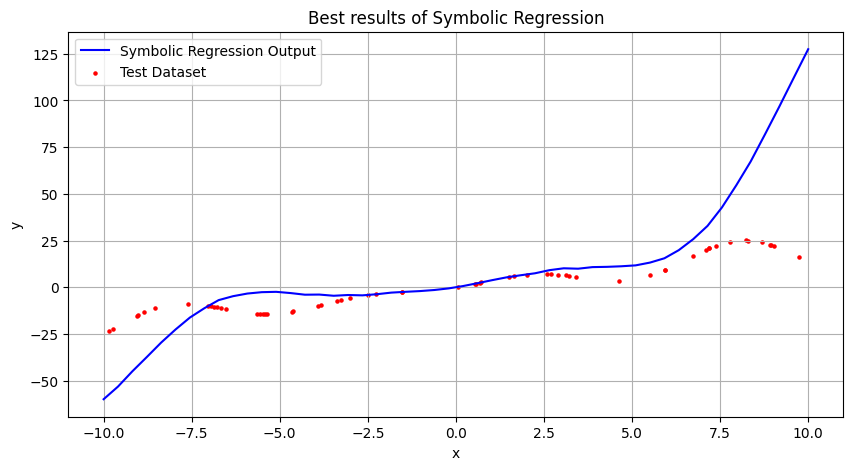

In [10]:
activation_funcs = [
    *[Constant()] * 2,
    *[Identity()] * 4,
    *[Square()] * 4,
    *[Sin()] * 2,
    *[Exp()] * 2,
    *[Sigmoid()] * 2,
    *[Product()] * 2,
]

var_names = ["x_1", "x_2"]      # This is the name of vars to show at the end.

n_layers = 2               # TODO: Number of hidden layers
reg_weight = 1e-4          # TODO: Regularization weight
learning_rate = 5e-3       # TODO: Learning rate
summary_step = 10        # TODO: Number of steps between logging summaries
epochs = 5000             # TODO: Number of epochs
trials = 5                 # TODO: Number of trials. note that it should be at least 5.

best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))

Running on device: cuda

----- Trial 1/5 -----


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 10.703438
Epoch    10  Loss 6.661012
Epoch    20  Loss 0.694046
Epoch    30  Loss 0.169008
Epoch    40  Loss 0.072607
Epoch    50  Loss 0.036387
Epoch    60  Loss 0.027491
Epoch    70  Loss 0.013020
Epoch    80  Loss 0.010903
Epoch    90  Loss 0.009952
Epoch   100  Loss 0.009472
Epoch   110  Loss 0.009471
Epoch   120  Loss 0.009391
Epoch   130  Loss 0.009359
Epoch   140  Loss 0.009328
Epoch   150  Loss 0.009306
Epoch   160  Loss 0.009286
Epoch   170  Loss 0.009270
Epoch   180  Loss 0.009254
Epoch   190  Loss 0.009240
Epoch   200  Loss 0.009226
Epoch   210  Loss 0.009214
Epoch   220  Loss 0.009202
Epoch   230  Loss 0.009191
Epoch   240  Loss 0.009181
Epoch   250  Loss 0.009171
Epoch   260  Loss 0.009162
Epoch   270  Loss 0.009154
Epoch   280  Loss 0.009145
Epoch   290  Loss 0.009137
Epoch   300  Loss 0.009130
Epoch   310  Loss 0.009123
Epoch   320  Loss 0.009116
Epoch   330  Loss 0.009109
Epoch   340  Loss 0.009103
Epoch   350  Loss 0.009097
Epoch   360  Loss 0.009091


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 12.241035
Epoch    10  Loss 8.281488
Epoch    20  Loss 1.394879
Epoch    30  Loss 0.373322
Epoch    40  Loss 0.081900
Epoch    50  Loss 0.052701
Epoch    60  Loss 0.027805
Epoch    70  Loss 0.014930
Epoch    80  Loss 0.011615
Epoch    90  Loss 0.010328
Epoch   100  Loss 0.009699
Epoch   110  Loss 0.009428
Epoch   120  Loss 0.009316
Epoch   130  Loss 0.009219
Epoch   140  Loss 0.009154
Epoch   150  Loss 0.009102
Epoch   160  Loss 0.009059
Epoch   170  Loss 0.009022
Epoch   180  Loss 0.008990
Epoch   190  Loss 0.008963
Epoch   200  Loss 0.008939
Epoch   210  Loss 0.008918
Epoch   220  Loss 0.008899
Epoch   230  Loss 0.008882
Epoch   240  Loss 0.008866
Epoch   250  Loss 0.008852
Epoch   260  Loss 0.008839
Epoch   270  Loss 0.008827
Epoch   280  Loss 0.008815
Epoch   290  Loss 0.008804
Epoch   300  Loss 0.008794
Epoch   310  Loss 0.008785
Epoch   320  Loss 0.008776
Epoch   330  Loss 0.008768
Epoch   340  Loss 0.008761
Epoch   350  Loss 0.008754
Epoch   360  Loss 0.008749


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.173843
Epoch    10  Loss 5.623503
Epoch    20  Loss 1.802839
Epoch    30  Loss 0.777490
Epoch    40  Loss 0.142498
Epoch    50  Loss 0.055562
Epoch    60  Loss 0.023353
Epoch    70  Loss 0.018583
Epoch    80  Loss 0.011505
Epoch    90  Loss 0.010634
Epoch   100  Loss 0.009517
Epoch   110  Loss 0.009284
Epoch   120  Loss 0.009240
Epoch   130  Loss 0.009158
Epoch   140  Loss 0.009123
Epoch   150  Loss 0.009096
Epoch   160  Loss 0.009072
Epoch   170  Loss 0.009052
Epoch   180  Loss 0.009034
Epoch   190  Loss 0.009018
Epoch   200  Loss 0.009003
Epoch   210  Loss 0.008989
Epoch   220  Loss 0.008976
Epoch   230  Loss 0.008965
Epoch   240  Loss 0.008954
Epoch   250  Loss 0.008944
Epoch   260  Loss 0.008935
Epoch   270  Loss 0.008926
Epoch   280  Loss 0.008918
Epoch   290  Loss 0.008911
Epoch   300  Loss 0.008904
Epoch   310  Loss 0.008897
Epoch   320  Loss 0.008891
Epoch   330  Loss 0.008885
Epoch   340  Loss 0.008880
Epoch   350  Loss 0.008874
Epoch   360  Loss 0.008869


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.033138
Epoch    10  Loss 5.318385
Epoch    20  Loss 0.598372
Epoch    30  Loss 0.335022
Epoch    40  Loss 0.061741
Epoch    50  Loss 0.022647
Epoch    60  Loss 0.016208
Epoch    70  Loss 0.010260
Epoch    80  Loss 0.010035
Epoch    90  Loss 0.009261
Epoch   100  Loss 0.009132
Epoch   110  Loss 0.009066
Epoch   120  Loss 0.009029
Epoch   130  Loss 0.009010
Epoch   140  Loss 0.009001
Epoch   150  Loss 0.008992
Epoch   160  Loss 0.008985
Epoch   170  Loss 0.008979
Epoch   180  Loss 0.008973
Epoch   190  Loss 0.008968
Epoch   200  Loss 0.008963
Epoch   210  Loss 0.008959
Epoch   220  Loss 0.008955
Epoch   230  Loss 0.008951
Epoch   240  Loss 0.008947
Epoch   250  Loss 0.008944
Epoch   260  Loss 0.008940
Epoch   270  Loss 0.008937
Epoch   280  Loss 0.008934
Epoch   290  Loss 0.008930
Epoch   300  Loss 0.008927
Epoch   310  Loss 0.008924
Epoch   320  Loss 0.008921
Epoch   330  Loss 0.008919
Epoch   340  Loss 0.008916
Epoch   350  Loss 0.008913
Epoch   360  Loss 0.008910


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 10.782201
Epoch    10  Loss 6.948673
Epoch    20  Loss 0.584349
Epoch    30  Loss 0.056254
Epoch    40  Loss 0.070245
Epoch    50  Loss 0.020863
Epoch    60  Loss 0.018018
Epoch    70  Loss 0.012599
Epoch    80  Loss 0.011385
Epoch    90  Loss 0.010796
Epoch   100  Loss 0.010267
Epoch   110  Loss 0.010120
Epoch   120  Loss 0.010001
Epoch   130  Loss 0.009915
Epoch   140  Loss 0.009859
Epoch   150  Loss 0.009818
Epoch   160  Loss 0.009786
Epoch   170  Loss 0.009759
Epoch   180  Loss 0.009734
Epoch   190  Loss 0.009712
Epoch   200  Loss 0.009690
Epoch   210  Loss 0.009670
Epoch   220  Loss 0.009651
Epoch   230  Loss 0.009633
Epoch   240  Loss 0.009615
Epoch   250  Loss 0.009599
Epoch   260  Loss 0.009583
Epoch   270  Loss 0.009569
Epoch   280  Loss 0.009555
Epoch   290  Loss 0.009541
Epoch   300  Loss 0.009529
Epoch   310  Loss 0.009517
Epoch   320  Loss 0.009505
Epoch   330  Loss 0.009494
Epoch   340  Loss 0.009484
Epoch   350  Loss 0.009474
Epoch   360  Loss 0.009464


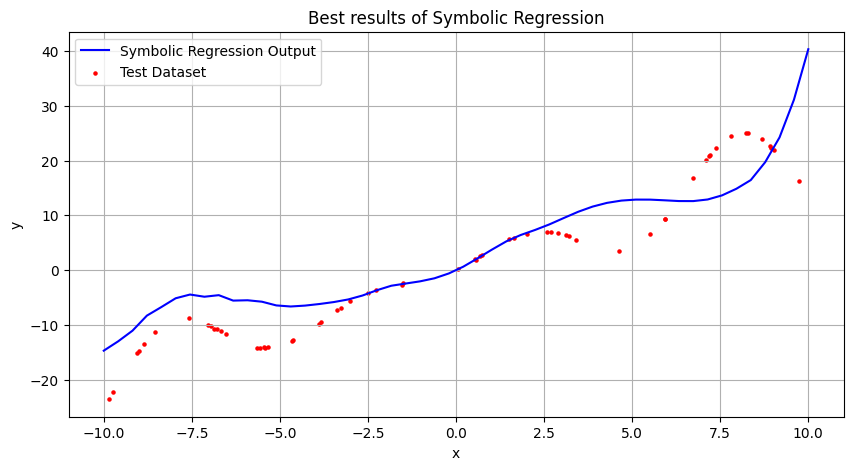

Running on device: cuda

----- Trial 1/5 -----


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 10.518825
Epoch    10  Loss 7.892253
Epoch    20  Loss 0.627996
Epoch    30  Loss 0.044251
Epoch    40  Loss 0.036427
Epoch    50  Loss 0.031969
Epoch    60  Loss 0.016110
Epoch    70  Loss 0.012192
Epoch    80  Loss 0.011532
Epoch    90  Loss 0.011034
Epoch   100  Loss 0.010601
Epoch   110  Loss 0.010283
Epoch   120  Loss 0.010040
Epoch   130  Loss 0.009864
Epoch   140  Loss 0.009736
Epoch   150  Loss 0.009640
Epoch   160  Loss 0.009568
Epoch   170  Loss 0.009509
Epoch   180  Loss 0.009459
Epoch   190  Loss 0.009416
Epoch   200  Loss 0.009376
Epoch   210  Loss 0.009340
Epoch   220  Loss 0.009306
Epoch   230  Loss 0.009274
Epoch   240  Loss 0.009244
Epoch   250  Loss 0.009215
Epoch   260  Loss 0.009188
Epoch   270  Loss 0.009161
Epoch   280  Loss 0.009136
Epoch   290  Loss 0.009298
Epoch   300  Loss 0.027997
Epoch   310  Loss 0.011223
Epoch   320  Loss 0.010312
Epoch   330  Loss 0.009363
Epoch   340  Loss 0.009323
Epoch   350  Loss 0.009278
Epoch   360  Loss 0.009190


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.800234
Epoch    10  Loss 8.690876
Epoch    20  Loss 2.461265
Epoch    30  Loss 0.112761
Epoch    40  Loss 0.066723
Epoch    50  Loss 0.031673
Epoch    60  Loss 0.025072
Epoch    70  Loss 0.015991
Epoch    80  Loss 0.013002
Epoch    90  Loss 0.010757
Epoch   100  Loss 0.009912
Epoch   110  Loss 0.009663
Epoch   120  Loss 0.009487
Epoch   130  Loss 0.009376
Epoch   140  Loss 0.009308
Epoch   150  Loss 0.009255
Epoch   160  Loss 0.009259
Epoch   170  Loss 0.024184
Epoch   180  Loss 0.009322
Epoch   190  Loss 0.010891
Epoch   200  Loss 0.009941
Epoch   210  Loss 0.009155
Epoch   220  Loss 0.009110
Epoch   230  Loss 0.009038
Epoch   240  Loss 0.009016
Epoch   250  Loss 0.008987
Epoch   260  Loss 0.008970
Epoch   270  Loss 0.008957
Epoch   280  Loss 0.008945
Epoch   290  Loss 0.008934
Epoch   300  Loss 0.008925
Epoch   310  Loss 0.008916
Epoch   320  Loss 0.008907
Epoch   330  Loss 0.008900
Epoch   340  Loss 0.008893
Epoch   350  Loss 0.008886
Epoch   360  Loss 0.008880


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 11.616744
Epoch    10  Loss 7.341618
Epoch    20  Loss 0.394322
Epoch    30  Loss 0.070635
Epoch    40  Loss 0.064450
Epoch    50  Loss 0.018092
Epoch    60  Loss 0.012150
Epoch    70  Loss 0.012041
Epoch    80  Loss 0.011095
Epoch    90  Loss 0.010638
Epoch   100  Loss 0.010337
Epoch   110  Loss 0.010072
Epoch   120  Loss 0.009875
Epoch   130  Loss 0.009735
Epoch   140  Loss 0.009630
Epoch   150  Loss 0.009543
Epoch   160  Loss 0.009464
Epoch   170  Loss 0.009397
Epoch   180  Loss 0.009344
Epoch   190  Loss 0.024457
Epoch   200  Loss 0.045593
Epoch   210  Loss 0.010420
Epoch   220  Loss 0.014112
Epoch   230  Loss 0.009231
Epoch   240  Loss 0.009518
Epoch   250  Loss 0.009179
Epoch   260  Loss 0.009149
Epoch   270  Loss 0.009066
Epoch   280  Loss 0.009049
Epoch   290  Loss 0.009035
Epoch   300  Loss 0.009022
Epoch   310  Loss 0.009011
Epoch   320  Loss 0.009001
Epoch   330  Loss 0.008991
Epoch   340  Loss 0.008983
Epoch   350  Loss 0.008975
Epoch   360  Loss 0.008968


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 12.409732
Epoch    10  Loss 4.540348
Epoch    20  Loss 1.676351
Epoch    30  Loss 0.342132
Epoch    40  Loss 0.127984
Epoch    50  Loss 0.060938
Epoch    60  Loss 0.020470
Epoch    70  Loss 0.014765
Epoch    80  Loss 0.011005
Epoch    90  Loss 0.010472
Epoch   100  Loss 0.009760
Epoch   110  Loss 0.009510
Epoch   120  Loss 0.009445
Epoch   130  Loss 0.009408
Epoch   140  Loss 0.009368
Epoch   150  Loss 0.009337
Epoch   160  Loss 0.009312
Epoch   170  Loss 0.009292
Epoch   180  Loss 0.009274
Epoch   190  Loss 0.009259
Epoch   200  Loss 0.009246
Epoch   210  Loss 0.009234
Epoch   220  Loss 0.009223
Epoch   230  Loss 0.009213
Epoch   240  Loss 0.009204
Epoch   250  Loss 0.009195
Epoch   260  Loss 0.009186
Epoch   270  Loss 0.009178
Epoch   280  Loss 0.009169
Epoch   290  Loss 0.009162
Epoch   300  Loss 0.009154
Epoch   310  Loss 0.009147
Epoch   320  Loss 0.009139
Epoch   330  Loss 0.009132
Epoch   340  Loss 0.009126
Epoch   350  Loss 0.009119
Epoch   360  Loss 0.009112


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 12.102439
Epoch    10  Loss 6.290470
Epoch    20  Loss 0.335757
Epoch    30  Loss 0.197088
Epoch    40  Loss 0.052421
Epoch    50  Loss 0.034892
Epoch    60  Loss 0.016839
Epoch    70  Loss 0.010928
Epoch    80  Loss 0.010532
Epoch    90  Loss 0.009644
Epoch   100  Loss 0.009326
Epoch   110  Loss 0.009168
Epoch   120  Loss 0.009111
Epoch   130  Loss 0.009080
Epoch   140  Loss 0.009055
Epoch   150  Loss 0.009033
Epoch   160  Loss 0.009014
Epoch   170  Loss 0.008996
Epoch   180  Loss 0.008980
Epoch   190  Loss 0.008966
Epoch   200  Loss 0.008952
Epoch   210  Loss 0.008940
Epoch   220  Loss 0.008928
Epoch   230  Loss 0.008918
Epoch   240  Loss 0.008908
Epoch   250  Loss 0.008899
Epoch   260  Loss 0.008891
Epoch   270  Loss 0.008883
Epoch   280  Loss 0.008875
Epoch   290  Loss 0.008869
Epoch   300  Loss 0.008862
Epoch   310  Loss 0.008856
Epoch   320  Loss 0.008850
Epoch   330  Loss 0.008845
Epoch   340  Loss 0.008840
Epoch   350  Loss 0.008836
Epoch   360  Loss 0.008831


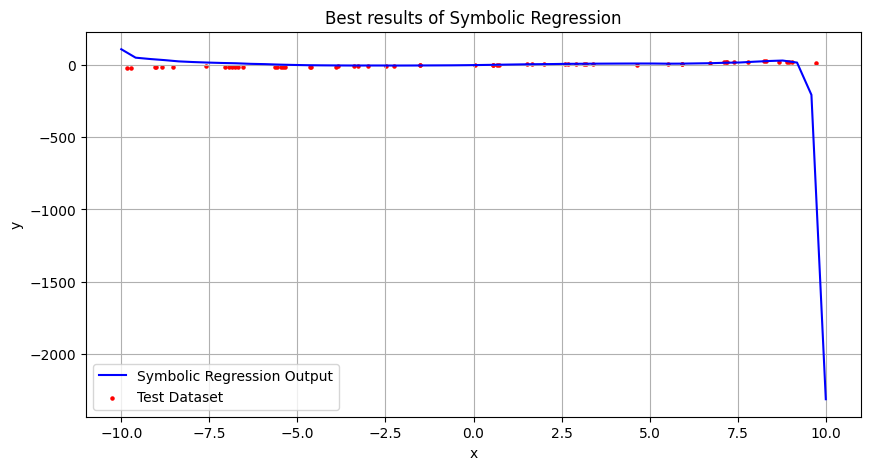

In [11]:
# Now, change the activation functions and the number of layers (n_layers) to observe the effect on the outputs.

for n_layers in range(3, 5):
    best_expr = run(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, trials)
    plot_symbolic(x_test, y_test, best_expr.replace("exp", "np.exp").replace("sin", "np.sin"))

We were previously working with the first dataset. Now, evaluate the model on the second dataset and extract the corresponding expression.

In [12]:
# TODO: Find expression for second dataset.
import pandas as pd

# =================================== TODO ===================================
# Load the second dataset from the specified path
df2 = pd.read_csv('/kaggle/input/dataset/dataset.csv')

# Prepare the data: features (X) and target (y)
X2 = df2[['x_1', 'x_2']].values
y2 = df2['y'].values.reshape(-1, 1)

# Split into training and testing sets for model evaluation
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)

# Convert numpy arrays to PyTorch tensors
x_train2_tensor = torch.from_numpy(X_train2).float()
y_train2_tensor = torch.from_numpy(y_train2).float()
x_test2_tensor = torch.from_numpy(X_test2).float()
y_test2_tensor = torch.from_numpy(y_test2).float()

print("\n--- Running Symbolic Regression on the second dataset ---")

# Define hyperparameters for this run. You may need to tune these for better results.
n_layers2 = 2
learning_rate2 = 5e-3
epochs2 = 5000
trials2 = 5

# Run the experiment
best_expr2 = run(x_train2_tensor, x_test2_tensor, y_train2_tensor, y_test2_tensor,
                 activation_funcs, n_layers2, learning_rate2, summary_step, epochs2, trials2)

print("\n-----------------------------------------------------")
print("Best expression found for the second dataset:")
print(best_expr2)
# ============================================================================


--- Running Symbolic Regression on the second dataset ---
Running on device: cuda

----- Trial 1/5 -----


  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 44865.683594
Epoch    10  Loss 43981.863281
Epoch    20  Loss 33252.199219
Epoch    30  Loss 6845.743652
Epoch    40  Loss 4743.610352
Epoch    50  Loss 3927.233643
Epoch    60  Loss 3346.957764
Epoch    70  Loss 3000.639404
Epoch    80  Loss 2681.800049
Epoch    90  Loss 2342.308350
Epoch   100  Loss 1896.154297
Epoch   110  Loss 1344.367188
Epoch   120  Loss 803.106140
Epoch   130  Loss 355.557526
Epoch   140  Loss 115.343117
Epoch   150  Loss 95.292122
Epoch   160  Loss 81.577209
Epoch   170  Loss 53.045605
Epoch   180  Loss 40.494736
Epoch   190  Loss 36.398304
Epoch   200  Loss 53.666348
Epoch   210  Loss 43.702457
Epoch   220  Loss 39.990490
Epoch   230  Loss 28.449432
Epoch   240  Loss 34.320133
Epoch   250  Loss 41.198769
Epoch   260  Loss 33.223572
Epoch   270  Loss 29.049046
Epoch   280  Loss 25.902685
Epoch   290  Loss 42.750469
Epoch   300  Loss 26.204742
Epoch   310  Loss 55.952724
Epoch   320  Loss 35.382660
Epoch   330  Loss 28.499683
Epoch   340  Loss 

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 44883.089844
Epoch    10  Loss 44626.609375
Epoch    20  Loss 43185.125000
Epoch    30  Loss 31204.462891
Epoch    40  Loss 12021.315430
Epoch    50  Loss 8873.416016
Epoch    60  Loss 6763.563477
Epoch    70  Loss 5168.415527
Epoch    80  Loss 4163.042480
Epoch    90  Loss 3396.134521
Epoch   100  Loss 2764.932373
Epoch   110  Loss 2212.811768
Epoch   120  Loss 1718.500854
Epoch   130  Loss 1273.162109
Epoch   140  Loss 808.609680
Epoch   150  Loss 335.814941
Epoch   160  Loss 177.207458
Epoch   170  Loss 131.835190
Epoch   180  Loss 107.139320
Epoch   190  Loss 85.902657
Epoch   200  Loss 76.760338
Epoch   210  Loss 70.096741
Epoch   220  Loss 64.478363
Epoch   230  Loss 59.791851
Epoch   240  Loss 55.590076
Epoch   250  Loss 51.937317
Epoch   260  Loss 48.687450
Epoch   270  Loss 45.757782
Epoch   280  Loss 43.256794
Epoch   290  Loss 40.845894
Epoch   300  Loss 38.715977
Epoch   310  Loss 36.758068
Epoch   320  Loss 35.103237
Epoch   330  Loss 33.817986
Epoch   34

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 44891.550781
Epoch    10  Loss 44575.957031
Epoch    20  Loss 42578.937500
Epoch    30  Loss 26808.634766
Epoch    40  Loss 9824.932617
Epoch    50  Loss 4989.589844
Epoch    60  Loss 4122.604004
Epoch    70  Loss 3639.272217
Epoch    80  Loss 3186.411865
Epoch    90  Loss 2853.715576
Epoch   100  Loss 2559.744629
Epoch   110  Loss 2302.462646
Epoch   120  Loss 2056.663330
Epoch   130  Loss 1816.715698
Epoch   140  Loss 1546.698120
Epoch   150  Loss 1179.753906
Epoch   160  Loss 725.154419
Epoch   170  Loss 478.301971
Epoch   180  Loss 351.613373
Epoch   190  Loss 282.804199
Epoch   200  Loss 244.424484
Epoch   210  Loss 214.428055
Epoch   220  Loss 193.527390
Epoch   230  Loss 178.047760
Epoch   240  Loss 166.119202
Epoch   250  Loss 156.220291
Epoch   260  Loss 147.943726
Epoch   270  Loss 140.944321
Epoch   280  Loss 134.787491
Epoch   290  Loss 129.110992
Epoch   300  Loss 123.710892
Epoch   310  Loss 118.467064
Epoch   320  Loss 113.286331
Epoch   330  Loss 108.0

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 44871.246094
Epoch    10  Loss 44529.902344
Epoch    20  Loss 41185.949219
Epoch    30  Loss 15451.249023
Epoch    40  Loss 6601.491699
Epoch    50  Loss 5049.375488
Epoch    60  Loss 4173.557617
Epoch    70  Loss 3720.674561
Epoch    80  Loss 3120.834717
Epoch    90  Loss 2625.881592
Epoch   100  Loss 2120.305908
Epoch   110  Loss 1582.236938
Epoch   120  Loss 1026.768921
Epoch   130  Loss 532.081055
Epoch   140  Loss 332.510315
Epoch   150  Loss 275.306885
Epoch   160  Loss 219.044479
Epoch   170  Loss 172.661942
Epoch   180  Loss 133.223145
Epoch   190  Loss 88.288200
Epoch   200  Loss 56.808865
Epoch   210  Loss 41.979218
Epoch   220  Loss 34.706234
Epoch   230  Loss 30.980268
Epoch   240  Loss 29.210072
Epoch   250  Loss 29.056574
Epoch   260  Loss 30.133924
Epoch   270  Loss 27.845112
Epoch   280  Loss 26.611481
Epoch   290  Loss 25.877563
Epoch   300  Loss 25.444347
Epoch   310  Loss 24.969202
Epoch   320  Loss 24.534353
Epoch   330  Loss 24.223783
Epoch   340 

  0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0  Loss 44951.492188
Epoch    10  Loss 44209.285156
Epoch    20  Loss 37785.042969
Epoch    30  Loss 5251.338867
Epoch    40  Loss 6074.318359
Epoch    50  Loss 4445.603027
Epoch    60  Loss 4167.398438
Epoch    70  Loss 3856.505127
Epoch    80  Loss 3445.771973
Epoch    90  Loss 3135.453613
Epoch   100  Loss 2867.696045
Epoch   110  Loss 2599.413818
Epoch   120  Loss 2318.830078
Epoch   130  Loss 2017.602783
Epoch   140  Loss 1583.243408
Epoch   150  Loss 1324.468140
Epoch   160  Loss 1147.414429
Epoch   170  Loss 628.323792
Epoch   180  Loss 381.569092
Epoch   190  Loss 256.273895
Epoch   200  Loss 163.656082
Epoch   210  Loss 117.181839
Epoch   220  Loss 84.557945
Epoch   230  Loss 64.135979
Epoch   240  Loss 49.687481
Epoch   250  Loss 39.282135
Epoch   260  Loss 31.588074
Epoch   270  Loss 194.512131
Epoch   280  Loss 39.886074
Epoch   290  Loss 36.777733
Epoch   300  Loss 42.700565
Epoch   310  Loss 28.940271
Epoch   320  Loss 23.003210
Epoch   330  Loss 19.405293
Epoch

### Bonus

We know that in the first and second dataset, the expression is simple and contains only one or at most two terms. However, as you can see, the expressions here are quite long. Now, think about what adjustments you can make to simplify them and reduce their length.


--- Running with L1 regularization to find a simpler expression ---
Running on device: cuda with L1 reg_weight=0.005

----- Trial 1/5 -----


Training with L1:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0 Loss 11.848504 (MSE: 11.405811)
Epoch    10 Loss 6.208834 (MSE: 5.831278)
Epoch    20 Loss 2.698148 (MSE: 2.342120)
Epoch    30 Loss 1.504932 (MSE: 1.158970)
Epoch    40 Loss 0.607932 (MSE: 0.256063)
Epoch    50 Loss 0.395951 (MSE: 0.048551)
Epoch    60 Loss 0.361233 (MSE: 0.027896)
Epoch    70 Loss 0.335550 (MSE: 0.017868)
Epoch    80 Loss 0.316791 (MSE: 0.013110)
Epoch    90 Loss 0.302645 (MSE: 0.011225)
Epoch   100 Loss 0.290833 (MSE: 0.010979)
Epoch   110 Loss 0.280063 (MSE: 0.010691)
Epoch   120 Loss 0.270587 (MSE: 0.010674)
Epoch   130 Loss 0.262047 (MSE: 0.010634)
Epoch   140 Loss 0.254162 (MSE: 0.010586)
Epoch   150 Loss 0.247033 (MSE: 0.010549)
Epoch   160 Loss 0.240165 (MSE: 0.010501)
Epoch   170 Loss 0.233609 (MSE: 0.010458)
Epoch   180 Loss 0.227503 (MSE: 0.010534)
Epoch   190 Loss 0.221837 (MSE: 0.010423)
Epoch   200 Loss 0.217018 (MSE: 0.010742)
Epoch   210 Loss 0.211842 (MSE: 0.010370)
Epoch   220 Loss 0.207246 (MSE: 0.010346)
Epoch   230 Loss 0.202663 (MSE: 

Training with L1:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0 Loss 12.966249 (MSE: 12.532422)
Epoch    10 Loss 10.257092 (MSE: 9.892308)
Epoch    20 Loss 5.302152 (MSE: 4.940588)
Epoch    30 Loss 1.715833 (MSE: 1.320757)
Epoch    40 Loss 0.550286 (MSE: 0.151231)
Epoch    50 Loss 0.425053 (MSE: 0.029227)
Epoch    60 Loss 0.406645 (MSE: 0.024689)
Epoch    70 Loss 0.383870 (MSE: 0.017745)
Epoch    80 Loss 0.362653 (MSE: 0.011061)
Epoch    90 Loss 0.348143 (MSE: 0.010588)
Epoch   100 Loss 0.334900 (MSE: 0.010165)
Epoch   110 Loss 0.322818 (MSE: 0.010074)
Epoch   120 Loss 0.311855 (MSE: 0.010046)
Epoch   130 Loss 0.301524 (MSE: 0.010026)
Epoch   140 Loss 0.291938 (MSE: 0.009985)
Epoch   150 Loss 0.282993 (MSE: 0.009919)
Epoch   160 Loss 0.274571 (MSE: 0.009849)
Epoch   170 Loss 0.266705 (MSE: 0.009812)
Epoch   180 Loss 0.259256 (MSE: 0.009790)
Epoch   190 Loss 0.252264 (MSE: 0.009784)
Epoch   200 Loss 0.245604 (MSE: 0.009797)
Epoch   210 Loss 0.239397 (MSE: 0.009796)
Epoch   220 Loss 0.233461 (MSE: 0.009758)
Epoch   230 Loss 0.227560 (MSE:

Training with L1:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0 Loss 11.811389 (MSE: 11.356775)
Epoch    10 Loss 8.450392 (MSE: 8.070172)
Epoch    20 Loss 1.731375 (MSE: 1.361936)
Epoch    30 Loss 0.544472 (MSE: 0.172496)
Epoch    40 Loss 0.448112 (MSE: 0.096157)
Epoch    50 Loss 0.369619 (MSE: 0.038017)
Epoch    60 Loss 0.335230 (MSE: 0.021808)
Epoch    70 Loss 0.314154 (MSE: 0.015963)
Epoch    80 Loss 0.298565 (MSE: 0.013050)
Epoch    90 Loss 0.286325 (MSE: 0.012315)
Epoch   100 Loss 0.275799 (MSE: 0.011887)
Epoch   110 Loss 0.266480 (MSE: 0.011533)
Epoch   120 Loss 0.258269 (MSE: 0.011316)
Epoch   130 Loss 0.250505 (MSE: 0.011178)
Epoch   140 Loss 0.243146 (MSE: 0.011073)
Epoch   150 Loss 0.236252 (MSE: 0.010999)
Epoch   160 Loss 0.230153 (MSE: 0.010937)
Epoch   170 Loss 0.224384 (MSE: 0.010912)
Epoch   180 Loss 0.218645 (MSE: 0.010862)
Epoch   190 Loss 0.213269 (MSE: 0.010837)
Epoch   200 Loss 0.208119 (MSE: 0.010829)
Epoch   210 Loss 0.203219 (MSE: 0.010839)
Epoch   220 Loss 0.198584 (MSE: 0.010823)
Epoch   230 Loss 0.194021 (MSE: 

Training with L1:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0 Loss 10.855709 (MSE: 10.407380)
Epoch    10 Loss 5.417848 (MSE: 5.030809)
Epoch    20 Loss 0.622579 (MSE: 0.246220)
Epoch    30 Loss 0.498580 (MSE: 0.133356)
Epoch    40 Loss 0.382203 (MSE: 0.035890)
Epoch    50 Loss 0.345356 (MSE: 0.018757)
Epoch    60 Loss 0.325758 (MSE: 0.016599)
Epoch    70 Loss 0.307471 (MSE: 0.013257)
Epoch    80 Loss 0.292296 (MSE: 0.011074)
Epoch    90 Loss 0.280021 (MSE: 0.010622)
Epoch   100 Loss 0.269599 (MSE: 0.010303)
Epoch   110 Loss 0.259821 (MSE: 0.010097)
Epoch   120 Loss 0.250895 (MSE: 0.009997)
Epoch   130 Loss 0.242800 (MSE: 0.009934)
Epoch   140 Loss 0.235938 (MSE: 0.010050)
Epoch   150 Loss 0.229537 (MSE: 0.010213)
Epoch   160 Loss 0.222997 (MSE: 0.009953)
Epoch   170 Loss 0.216976 (MSE: 0.009865)
Epoch   180 Loss 0.211139 (MSE: 0.009976)
Epoch   190 Loss 0.205616 (MSE: 0.010102)
Epoch   200 Loss 0.200342 (MSE: 0.010246)
Epoch   210 Loss 0.195709 (MSE: 0.010674)
Epoch   220 Loss 0.189919 (MSE: 0.009767)
Epoch   230 Loss 0.186226 (MSE: 

Training with L1:   0%|          | 0/5000 [00:00<?, ?it/s]

Epoch     0 Loss 12.782578 (MSE: 12.335299)
Epoch    10 Loss 9.323057 (MSE: 8.955624)
Epoch    20 Loss 2.814071 (MSE: 2.462754)
Epoch    30 Loss 1.189829 (MSE: 0.848699)
Epoch    40 Loss 0.446311 (MSE: 0.103403)
Epoch    50 Loss 0.407544 (MSE: 0.076550)
Epoch    60 Loss 0.336641 (MSE: 0.021055)
Epoch    70 Loss 0.318803 (MSE: 0.017268)
Epoch    80 Loss 0.300424 (MSE: 0.010819)
Epoch    90 Loss 0.288807 (MSE: 0.010523)
Epoch   100 Loss 0.278057 (MSE: 0.010083)
Epoch   110 Loss 0.268777 (MSE: 0.010007)
Epoch   120 Loss 0.260197 (MSE: 0.009945)
Epoch   130 Loss 0.252532 (MSE: 0.009900)
Epoch   140 Loss 0.245300 (MSE: 0.009874)
Epoch   150 Loss 0.238517 (MSE: 0.009836)
Epoch   160 Loss 0.232155 (MSE: 0.009787)
Epoch   170 Loss 0.226515 (MSE: 0.009709)
Epoch   180 Loss 0.221185 (MSE: 0.009616)
Epoch   190 Loss 0.216157 (MSE: 0.009569)
Epoch   200 Loss 0.211534 (MSE: 0.009531)
Epoch   210 Loss 0.207278 (MSE: 0.009521)
Epoch   220 Loss 0.203203 (MSE: 0.009530)
Epoch   230 Loss 0.199266 (MSE: 

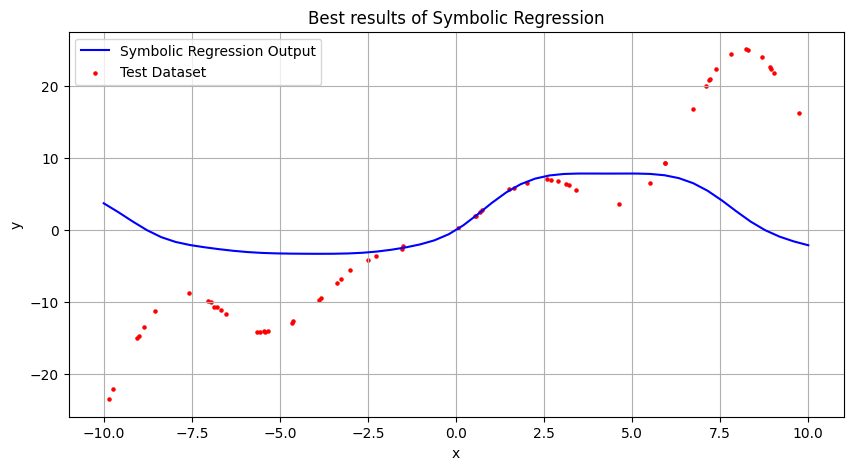

In [13]:
# TODO
# --- Code Modification ---
# To simplify expressions, we add L1 regularization to the loss function.
# This requires modifying the `train` and `run` functions to handle a `reg_weight` parameter.

def train_with_l1(
    x_train, y_train, activation_funcs, in_dim, n_layers,
    learning_rate, summary_step, epochs, reg_weight, device="cuda"
):
    """Modified train function to include an L1 regularization penalty."""
    device = "cuda" if (device == "cuda" and torch.cuda.is_available()) else "cpu"
    net = SymbolicNet(n_layers, in_dim=in_dim, funcs=activation_funcs).to(device)
    opt = optim.Adam(net.parameters(), lr=learning_rate) # L2 regularization (weight_decay) can also be used
    x_train, y_train = x_train.to(device), y_train.to(device)

    # Use a while loop to restart training if loss becomes NaN
    while True:
        nan_found = False
        for ep in tqdm(range(epochs), total=epochs, desc="Training with L1"):
            opt.zero_grad()
            out = net(x_train)
            mse_loss = F.mse_loss(out, y_train)

            # Calculate L1 penalty
            l1_penalty = 0
            for param in net.parameters():
                l1_penalty += torch.norm(param, 1)

            # Add L1 penalty to the loss
            loss = mse_loss + reg_weight * l1_penalty

            if torch.isnan(loss):
                print("Loss is NaN, restarting trial.")
                nan_found = True
                break

            loss.backward()
            opt.step()

            if summary_step and ep % summary_step == 0:
                print(f"Epoch {ep:5d} Loss {loss.item():.6f} (MSE: {mse_loss.item():.6f})")
        
        if not nan_found:
            return net # Return trained network if successful

# We also need a modified run function to use train_with_l1
def run_with_l1(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, reg_weight, trials=5):
    test_losses, expressions = [], []
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Running on device: {device} with L1 reg_weight={reg_weight}")

    for i in range(trials):
        print(f"\n----- Trial {i+1}/{trials} -----")
        net = train_with_l1(x_train, y_train, activation_funcs, x_train.shape[1], n_layers, learning_rate, summary_step, epochs, reg_weight, device=device)
        if net is None: continue # Skip failed trials

        test_loss = test(net, x_test, y_test, device=device)
        test_losses.append(test_loss)
        expr = find_expression(net, x_train.shape[1])
        expressions.append(expr)
        print(f"Trial {i+1} Test Loss: {test_loss:.4f}, Expression: {expr}")

    if not test_losses:
        return "No successful trials."

    best_index = np.argmin(np.array(test_losses))
    return str(expressions[best_index])


# --- Example Run with L1 Regularization on the First Dataset ---
print("\n--- Running with L1 regularization to find a simpler expression ---")
# A higher regularization weight forces more sparsity. You may need to tune this value.
l1_reg_weight = 5e-3
best_expr_simple = run_with_l1(x_train, x_test, y_train, y_test, activation_funcs, n_layers, learning_rate, summary_step, epochs, l1_reg_weight, trials)

print("\n-----------------------------------------------------")
print("Best expression with L1 regularization:")
print(best_expr_simple)
plot_symbolic(x_test, y_test, best_expr_simple.replace("exp", "np.exp").replace("sin", "np.sin"))

# Note: Another simple way to get shorter expressions is to increase the `threshold`
# parameter in the `get_expression` function, which filters out terms with small coefficients.

# Seq2Seq-Based Symbolic Regression with Transformers

<p align="center">
  <img style="margin-top: 30px" src="https://cdn.botpenguin.com/assets/website/Sequence_to_Sequence_Models_0b5fb158a1.webp" width="500">
</p>

Symbolic regression is a method that aims to find a mathematical expression that best fits a given dataset. Unlike traditional regression techniques, symbolic regression does not assume a predefined function structure; instead, it searches for an optimal mathematical expression that relates input features to target variables. One effective approach to symbolic regression is using sequence-to-sequence (Seq2Seq) models based on transformers.

### Overview of Seq2Seq Models in Symbolic Regression:
A Seq2Seq model consists of an encoder and a decoder, both of which are typically built using transformer architectures. The main idea is to treat symbolic regression as a sequence translation problem, where:
- The input is a set of numerical data points (features).
- The output is a mathematical expression represented as a sequence of tokens.
- This approach allows the model to learn a mapping from numerical inputs to symbolic expressions, making it a powerful tool for symbolic regression.

### Encoder: Processing the Input Data

The encoder in a Seq2Seq transformer is responsible for encoding the full dataset into a latent representation. Here’s how it works:

1. Tokenization: The input dataset (typically a set of feature-value pairs) is transformed into a sequence of tokens. Each token can represent a numerical value or a special marker that indicates structural information.

2. Embedding Layer: The numerical tokens are converted into dense vector representations using an embedding layer.

3. Positional Encoding: Since transformers do not have built-in recurrence mechanisms, positional encodings are added to the embeddings to retain the order of the input sequence.

4. Self-Attention Mechanism: The encoder consists of multiple self-attention layers that allow the model to weigh the importance of different parts of the input sequence dynamically.

5. Output Representation: The encoder outputs a context-aware representation of the input sequence, which is then passed to the decoder.

### Decoder: Generating the Mathematical Expression
The decoder takes the encoder’s output and generates the target sequence, which is a symbolic mathematical expression. This process follows these steps:

1. Input Token Embedding: The decoder receives an initial input token (typically a start-of-sequence token <SOS>).

2. Self-Attention Layers: The decoder generates tokens one by one, attending to previously generated tokens using masked self-attention.

3. Cross-Attention with Encoder Outputs: The decoder also attends to the encoder’s output using cross-attention layers, ensuring that the generated expression is conditioned on the input data.

4. Token Generation via Softmax: The final layer applies a softmax function over the vocabulary (consisting of mathematical symbols, operators, and variables) to predict the next token.


In this section, we will implement symbolic regression using transformers. First, we generate the dataset and save it in the `data` folder. Do not modify the cell below. We suggest reading and understanding it first.

In [14]:
# Don't change this cell.

C, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, x1, x2, x3, x4, x5, x6', real=True, positive=True)

MY_VOCAB = np.array([
    ['add', 4, 2],  # binary operators
    ['sub', 3, 2],
    ['mul', 6, 2],
    ['sin', 1, 1],  # unary operators
    ['cos', 1, 1],
    ['log', 2, 1],
    ['exp', 2, 1],
    ['neg', 0, 1],
    ['inv', 3, 1],
    ['sq', 2, 1],
    ['cb', 0, 1],
    ['sqrt', 2, 1],
    ['cbrt', 0, 1],
    ['C', 8, 0],  # leaves
    ['x1', 8, 0],
    ['x2', 8, 0],
    ['x3', 4, 0],
    ['x4', 4, 0],
    ['x5', 2, 0],
    ['x6', 2, 0],
])


def generate_expression(vocab):
    """
    Recursive function!
    Generate one expression using the tokens and their
    respective probabiities provided by 'vocab'.
    """
    weights = vocab[:, 1].astype('float32')
    probs = weights / np.sum(weights)
    N = len(vocab)
    expr = []
    rand_idx = np.random.choice(N, p=probs)
    cur_token = vocab[rand_idx, 0]
    cur_arity = int(vocab[rand_idx, 2])
    expr.append(cur_token)
    if cur_arity==0:
        return expr
    else:
        if cur_token in ['sin', 'cos']:
            idx1 = np.where(vocab[:, 0]=='sin')[0][0]
            idx2 = np.where(vocab[:, 0]=='cos')[0][0]
            new_vocab = np.delete(vocab, [idx1, idx2], axis=0)
        elif cur_token in ['log', 'exp']:
            idx1 = np.where(vocab[:, 0]=='log')[0][0]
            idx2 = np.where(vocab[:, 0]=='exp')[0][0]
            new_vocab = np.delete(vocab, [idx1, idx2], axis=0)
        else:
            new_vocab = vocab
        if cur_arity==1:
            child = generate_expression(new_vocab)
            return expr + child
        elif cur_arity==2:
            child1 = generate_expression(new_vocab)
            child2 = generate_expression(new_vocab)
            return expr + child1 + child2


def translate_integers_into_tokens(seq_int):
    seq_tokens = []
    for n in range(len(seq_int)):
        if seq_int[n]>=2:
            seq_tokens.append(MY_VOCAB[seq_int[n]-2])
    return seq_tokens


def from_sequence_to_sympy(expr):    
    """
    Recursive function!
    Convert the initial sequence of tokens into SymPy expression.
    """


    MY_VOCAB = np.array([
        ['add', 4, 2],  # binary operators
        ['sub', 3, 2],
        ['mul', 6, 2],
        ['sin', 1, 1],  # unary operators
        ['cos', 1, 1],
        ['log', 2, 1],
        ['exp', 2, 1],
        ['neg', 0, 1],
        ['inv', 3, 1],
        ['sq', 2, 1],
        ['cb', 0, 1],
        ['sqrt', 2, 1],
        ['cbrt', 0, 1],
        ['C', 8, 0],  # leaves
        ['x1', 8, 0],
        ['x2', 8, 0],
        ['x3', 4, 0],
        ['x4', 4, 0],
        ['x5', 2, 0],
        ['x6', 2, 0],
    ])

    
    cur_token = expr[0]
    try:
        return float(cur_token)  # for cases when constants are evaluated
    except ValueError:
        cur_idx = np.where(MY_VOCAB[:, 0]==cur_token)[0][0]
        cur_arity = int(MY_VOCAB[cur_idx, 2])
    if cur_arity==0:
        if cur_token=='C':
            return C
        elif cur_token=='x1':
            return x1
        elif cur_token=='x2':
            return x2
        elif cur_token=='x3':
            return x3
        elif cur_token=='x4':
            return x4
        elif cur_token=='x5':
            return x5
        elif cur_token=='x6':
            return x6
    elif cur_arity==1:
        if cur_token=='sin':
            return sympy.sin(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='cos':
            return sympy.cos(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='log':
            return sympy.log(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='exp':
            return sympy.exp(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='neg':
            return - from_sequence_to_sympy(expr[1:])
        elif cur_token=='inv':
            return 1 / from_sequence_to_sympy(expr[1:])
        elif cur_token=='sq':
            return (from_sequence_to_sympy(expr[1:]))**2
        elif cur_token=='cb':
            return (from_sequence_to_sympy(expr[1:]))**3
        elif cur_token=='sqrt':
            return sympy.sqrt(from_sequence_to_sympy(expr[1:]))
        elif cur_token=='cbrt':
            return sympy.cbrt(from_sequence_to_sympy(expr[1:]))
    elif cur_arity==2:
        arity_count = 1
        idx_split = 1
        for temp_token in expr[1:]:
            try:
                float(temp_token)  # for cases when constants are evaluated
                arity_count += -1
            except ValueError:
                temp_idx = np.where(MY_VOCAB[:, 0]==temp_token)[0][0]
                arity_count += int(MY_VOCAB[temp_idx, 2]) - 1
            idx_split += 1
            if arity_count==0:
                break
        left_list = expr[1:idx_split]
        right_list = expr[idx_split:]
        if cur_token=='add':
            return from_sequence_to_sympy(left_list) + from_sequence_to_sympy(right_list)
        elif cur_token=='sub':
            return from_sequence_to_sympy(left_list) - from_sequence_to_sympy(right_list)
        elif cur_token=='mul':
            return from_sequence_to_sympy(left_list) * from_sequence_to_sympy(right_list)


def from_sequence_to_string(expr):
    """
    OBSOLETE
    Recursive function!
    Convert the initial sequence of tokens into a string
    which can be read by SymPy.
    """


    MY_VOCAB = np.array([
        ['add', 4, 2],  # binary operators
        ['sub', 3, 2],
        ['mul', 6, 2],
        ['sin', 1, 1],  # unary operators
        ['cos', 1, 1],
        ['log', 2, 1],
        ['exp', 2, 1],
        ['neg', 0, 1],
        ['inv', 3, 1],
        ['sq', 2, 1],
        ['cb', 0, 1],
        ['sqrt', 2, 1],
        ['cbrt', 0, 1],
        ['C', 8, 0],  # leaves
        ['x1', 8, 0],
        ['x2', 8, 0],
        ['x3', 4, 0],
        ['x4', 4, 0],
        ['x5', 2, 0],
        ['x6', 2, 0],
    ])
    
    cur_token = expr[0]
    try:
        float(cur_token)  # for cases when constants are evaluated
        cur_arity = 0
    except ValueError:
        cur_idx = np.where(MY_VOCAB[:, 0]==cur_token)[0][0]
        cur_arity = int(MY_VOCAB[cur_idx, 2])
    if cur_arity==0:
        return cur_token
    elif cur_arity==1:
        if cur_token=='inv':
            return '1/(' + from_sequence_to_string(expr[1:]) + ')'
        elif cur_token=='sq':
            return '(' + from_sequence_to_string(expr[1:]) + ')**2'
        elif cur_token=='cb':
            return '(' + from_sequence_to_string(expr[1:]) + ')**3'
        elif cur_token=='neg':
            return '-(' + from_sequence_to_string(expr[1:]) + ')'
        else:
            return cur_token + '(' + from_sequence_to_string(expr[1:]) + ')'
    elif cur_arity==2:
        arity_count = 1
        idx_split = 1
        for temp_token in expr[1:]:
            try:
                float(temp_token)  # for cases when constants are evaluated
                arity_count += -1
            except ValueError:
                temp_idx = np.where(MY_VOCAB[:, 0]==temp_token)[0][0]
                arity_count += int(MY_VOCAB[temp_idx, 2]) - 1
            idx_split += 1
            if arity_count==0:
                break
        left_list = expr[1:idx_split]
        right_list = expr[idx_split:]
        if cur_token=='add':
            return '(' + from_sequence_to_string(left_list) + ')+(' + from_sequence_to_string(right_list) + ')'
        elif cur_token=='sub':
            return '(' + from_sequence_to_string(left_list) + ')-(' + from_sequence_to_string(right_list) + ')'
        elif cur_token=='mul':
            return '(' + from_sequence_to_string(left_list) + ')*(' + from_sequence_to_string(right_list) + ')'


def expression_tree_depth(sympy_expr):
    """
    Recursive function!
    Count the maximum depth for a given SymPy expression.
    """
    if len(sympy_expr.args)==0:
        return 1
    elif len(sympy_expr.args)==1:
        return 1 + expression_tree_depth(sympy_expr.args[0])
    else:
        max_depth = 0
        for a in sympy_expr.args:
            temp_depth = expression_tree_depth(a)
            if temp_depth > max_depth:
                max_depth = temp_depth
        return 1 + max_depth


def first_variables_first(sympy_expr):
    """
    Counts the number of variables in the SymPy expression,
    and assign firte variables first.
    Example: log(x3)+x5 becomes log(x1)+x2
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    sympy_str = str(sympy_expr)
    exist = []
    for t in tokens:
        exist.append(t in sympy_str)
    for idx_new, idx_old in enumerate(np.where(exist)[0]):
        sympy_str = sympy_str.replace(f'x{idx_old+1}', f'x{idx_new+1}')
    sympy_expr = sympy.sympify(sympy_str)
    return sympy_expr


def from_sympy_to_sequence(sympy_expr):
    """
    Recursive function!
    Convert a SymPy expression into a standardized sequence of tokens,
    which will be used as the ground truth to train the ST.
    This function calls from_sympy_power_to_sequence,
    from_sympy_multiplication_to_sequence, and
    from_sympy_addition_to sequence.
    """
    if len(sympy_expr.args)==0:  # leaf
        return [str(sympy_expr)]
    elif len(sympy_expr.args)==1:  # unary operator
        return [str(sympy_expr.func)] + from_sympy_to_sequence(sympy_expr.args[0])
    elif len(sympy_expr.args)>=2:  # binary operator
        if sympy_expr.func==sympy.core.power.Pow:
            power_seq = from_sympy_power_to_sequence(sympy_expr.args[1])
            return power_seq + from_sympy_to_sequence(sympy_expr.args[0])
        elif sympy_expr.func==sympy.core.mul.Mul:
            return from_sympy_multiplication_to_sequence(sympy_expr)
        elif sympy_expr.func==sympy.core.add.Add:
            return from_sympy_addition_to_sequence(sympy_expr)


def from_sympy_power_to_sequence(exponent):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for power functions.
    """
    if exponent==(-4):
        return ['inv', 'sq', 'sq']
    elif exponent==(-3):
        return ['inv', 'cb']
    elif exponent==(-2):
        return ['inv', 'sq']
    elif exponent==(-3/2):
        return ['inv', 'cb', 'sqrt']
    elif exponent==(-1):
        return ['inv']
    elif exponent==(-1/2):
        return ['inv', 'sqrt']
    elif exponent==(-1/3):
        return ['inv', 'cbrt']
    elif exponent==(-1/4):
        return ['inv', 'sqrt', 'sqrt']
    elif exponent==(1/4):
        return ['sqrt', 'sqrt']
    elif exponent==(1/3):
        return ['cbrt']
    elif exponent==(1/2):
        return ['sqrt']
    elif exponent==(3/2):
        return ['cb', 'sqrt']
    elif exponent==(2):
        return ['sq']
    elif exponent==(3):
        return ['cb']
    elif exponent==(4):
        return ['sq', 'sq']
    else:
        return ['abort']


def from_sympy_multiplication_to_sequence(sympy_mul_expr):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for multiplications.
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    nb_factors = 0
    nb_constants = 0
    is_neg = False
    for n in range(len(sympy_mul_expr.args)):
        cur_fact = sympy_mul_expr.args[n]
        if cur_fact==(-1):
            is_neg = True
        if any(t in str(cur_fact) for t in tokens):
            nb_factors += 1
        else:
            nb_constants += 1
    seq = []
    if is_neg:
        seq.append('neg')
    for _ in range(nb_factors-1):
        seq.append('mul')
    if nb_constants>0:
        seq.append('mul')
        seq.append('C')
    for n in range(len(sympy_mul_expr.args)):
        cur_fact = sympy_mul_expr.args[n]
        if any(t in str(cur_fact) for t in tokens):
            seq = seq + from_sympy_to_sequence(cur_fact)
    return seq


def from_sympy_addition_to_sequence(sympy_add_expr):
    """
    C.f. from_sympy_to_sequence function.
    Standardize the sequence of tokens for additions.
    """
    tokens = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
    nb_terms = 0
    nb_constants = 0
    for n in range(len(sympy_add_expr.args)):
        cur_term = sympy_add_expr.args[n]
        if any(t in str(cur_term) for t in tokens):
            nb_terms += 1
        else:
            nb_constants += 1
    seq = []
    for _ in range(nb_terms-1):
        seq.append('add')
    if nb_constants>0:
        seq.append('add')
        seq.append('C')
    for n in range(len(sympy_add_expr.args)):
        cur_term = sympy_add_expr.args[n]
        if any(t in str(cur_term) for t in tokens):
            seq = seq + from_sympy_to_sequence(cur_term)
    return seq


def sample_from_sympy_expression(sympy_expr, nb_samples=200):
    """
    Sample from SymPy expression.
    Variables are first sampled using log-uniform distributions.
    """
    np_x = np.power(10.0, np.random.uniform(low=-1.0, high=1.0, size=(nb_samples, 6)))
    f = sympy.lambdify([x1, x2, x3, x4, x5, x6], sympy_expr)
    np_y = f(np_x[:, 0], np_x[:, 1], np_x[:, 2], np_x[:, 3], np_x[:, 4], np_x[:, 5])
    return np_y, np_x


def count_nb_variables_sympy_expr(sympy_expr):
    """
    Assumes that the variables are properly numbered, i.e.
    first_variables_first has been applied.
    Returns the number of variables in the SymPy expression.
    """
    nb_variables = 0
    while f'x{nb_variables+1}' in str(sympy_expr):
        nb_variables += 1
    return nb_variables
    
def is_tree_complete(seq_indices):
    """
    Check whether a given sequence of tokens defines
    a complete symbolic expression.
    """
    arity = 1
    for n in seq_indices:
        if n in [0, 1]:
            continue
            print('Predict padding or <SOS>, which is bad...')
        cur_token = MY_VOCAB[n-2]  # vocabulary is hard-coded, token 0 for padding, token 1 is <SOS>
        if cur_token in ['add', 'mul']:
            arity = arity + 2 - 1
        elif cur_token in ['sin', 'cos', 'log', 'exp', 'neg', 'inv', 'sqrt', 'sq', 'cb']:
            arity = arity + 1 - 1
        elif cur_token in ['C', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']:
            arity = arity + 0 - 1
    if arity==0:
        return True
    else:
        return False

In [15]:
# Don't change this cell.

# Number of initial trials
NB_TRAILS = 10000
# Minimum number of nodes (for the first crude filtering)
NB_NODES_MIN = 2
# Maximum number of nodes (for the first crude filtering)
NB_NODES_MAX = 15
# Maximum number of seconds to wait when SymPy tries to simplify
MAX_SEC_WAIT_SIMPLIFY = 5
# Minimum number of nodes (for the first crude filtering)
NB_NESTED_MAX = 6
# Minimum number of constants in the final sequences
NB_CONSTANTS_MIN = 1
# Maximum number of constants in the final sequences
NB_CONSTANTS_MAX = 1
# Maximum number of variables
NB_VARIABLES_MAX = 6
# Maximum sequence length possible (otherwise discard)
SEQ_LENGTH_MAX = 30
# Number of times we evaluate constants for each unique equation  -- BEFORE 100
NB_SAMPLING_PER_EQ = 25
# When sampling, if at least one point is above this magnitude, abort  -- BEFORE 1.0e12
ORDER_OF_MAG_LIMIT = 1.0e+9
# Number of sample points for the datasets  -- BEFORE 200
NB_SAMPLE_PTS = 50
# Variable representation: 'normal' is (y, x1, x2, ...), 'log' is log(abs(y, x1, x2, ...)), or 'both'
VARIABLE_TYPE = 'normal'
# Path output
PATH_OUT = 'data'
# Number zfill zeros
NB_ZFILL = 8

In [16]:
print('Generate a lot of expression trees...')
all_my_expr = []
percent = 0
for n in range(NB_TRAILS):
    if int((n+1)/NB_TRAILS*100.0) > percent:
        percent = int((n+1)/NB_TRAILS*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_expr = generate_expression(MY_VOCAB)
    all_my_expr.append(cur_expr)
print(f'Nb of expression trees generated = {NB_TRAILS}')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Select expressions with more than {NB_NODES_MIN} and less than {NB_NODES_MAX} nodes...')
my_expr_filter = []  # Remove too simple and very long expressions
for n in range(len(all_my_expr)):
    if len(all_my_expr[n])>=NB_NODES_MIN and len(all_my_expr[n])<=NB_NODES_MAX:
        my_expr_filter.append(all_my_expr[n])
print(f'Nb of remaining expressions = {len(my_expr_filter)}')

def handler(signum, frame):
    raise Exception('too long')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Remove invalid or very nested (>{NB_NESTED_MAX}) expressions...')
C, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, x1, x2, x3, x4, x5, x6', real=True, positive=True)
nb_timeout_abort = 0
list_pb = []
my_expr_sympy = []
percent = 0
for n in range(len(my_expr_filter)):
    if int((n+1)/len(my_expr_filter)*100.0) > percent:
        percent = int((n+1)/len(my_expr_filter)*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    try:
        sympy_expr = from_sequence_to_sympy(my_expr_filter[n])
        signal.signal(signal.SIGALRM, handler)
        signal.alarm(MAX_SEC_WAIT_SIMPLIFY)
        try:
            sympy_expr = sympy.factor(sympy_expr)
            sympy_expr = sympy.simplify(sympy_expr)  # so that all expressions are represented in the same way
        except Exception as e:
            nb_timeout_abort += 1
            list_pb.append(my_expr_filter[n])
            continue
        signal.alarm(0)
        if not 'zoo' in str(sympy_expr):  # only if valid expression
            if expression_tree_depth(sympy_expr) <= NB_NESTED_MAX:  # and max tree depth is not more than NB_NESTED_MAX
                sympy_expr = first_variables_first(sympy_expr)  # log(x3)+x5 becomes log(x1)+x2
                sympy_expr = sympy.factor(sympy_expr)
                sympy_expr = sympy.simplify(sympy_expr)  # so that all expressions are represented in the same way
                if 'x1' in str(sympy_expr):  # do not include if there is no variable anymore
                    my_expr_sympy.append(sympy_expr)
    except Exception as e:
        print(n, e)
        print(my_expr_filter[n])
print(f'Remaining SymPy expressions = {len(my_expr_sympy)}')
print(f'Nb aborts because timeout: {nb_timeout_abort}')

print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print('Clean the SymPy expression trees...')  # combine constants and rewrite powers/inverse/subtractions
print(f'Abort if Nb. const. < {NB_CONSTANTS_MIN} or Nb. const. > {NB_CONSTANTS_MAX}')
print(f'Abort is Nb. variables > {NB_VARIABLES_MAX}')
nb_pow_abort = 0
nb_const_min_abort = 0
nb_const_max_abort = 0
nb_var_max_abort = 0
nb_seqlen_abort = 0
my_expr_seq = []

for n in range(len(my_expr_sympy)):
    expr_seq = from_sympy_to_sequence(my_expr_sympy[n])
    if 'abort' in expr_seq:
        nb_pow_abort += 1
    else:
        if expr_seq.count('C') > NB_CONSTANTS_MAX:
            nb_const_max_abort += 1
        elif expr_seq.count('C') < NB_CONSTANTS_MIN:
            nb_const_min_abort += 1
        elif f'x{NB_VARIABLES_MAX+1}' in expr_seq:
            nb_var_max_abort += 1
        else:
            if len(expr_seq) > SEQ_LENGTH_MAX:
                nb_seqlen_abort += 1
            else:
                my_expr_seq.append(expr_seq)

print(f'Nb aborts because power exponent: {nb_pow_abort}')
print(f'Nb aborts because nb of constants: {nb_const_min_abort} and {nb_const_max_abort}')
print(f'Nb aborts because nb of variables: {nb_var_max_abort}')
print(f'Nb aborts because sequence length: {nb_seqlen_abort}')
print(f'=> Final number of expressions = {len(my_expr_seq)}')

temp = []
for n in range(len(my_expr_seq)):
    temp.append(str(my_expr_seq[n]))
temp = np.array(temp)
uniq, idx = np.unique(temp, return_index=True)

my_expr_uniq_seq = []
for n in idx:
    my_expr_uniq_seq.append(my_expr_seq[n])

print(f'\n** Number of unique expressions = {len(my_expr_uniq_seq)} **')


print('\n' + '[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']')
print(f'Create {NB_SAMPLING_PER_EQ} datasets per equation.')
print(f'Datasets have {NB_SAMPLE_PTS} rows.')
print(f'Abort if generated value above {ORDER_OF_MAG_LIMIT:.1e}')
if not os.path.exists(f'{PATH_OUT}/ground_truth'):
    os.makedirs(f'{PATH_OUT}/ground_truth')
if not os.path.exists(f'{PATH_OUT}/values'):
    os.makedirs(f'{PATH_OUT}/values')

count_datasets = 0
nb_order_mag_abort = 0
nb_sample_pts_abort = 0
other_pbs_list = []
percent = 0

for n1 in range(len(my_expr_uniq_seq)):
    if int((n1+1)/len(my_expr_uniq_seq)*100.0) > percent:
        percent = int((n1+1)/len(my_expr_uniq_seq)*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_seq = my_expr_uniq_seq[n1]
    try:
        for n2 in range(NB_SAMPLING_PER_EQ):
            temp = []
            cur_gt = []  # ground truth
            for n3 in range(len(cur_seq)):
                if cur_seq[n3]=='C':
                    const_val = np.round(np.random.uniform(low=-100.0, high=100.0), decimals=2)
                    temp.append(str(const_val))
                    cur_gt.append('C=' + str(const_val))
                else:
                    temp.append(cur_seq[n3])
                    cur_gt.append(cur_seq[n3])

            try:
                cur_sympy_expr = from_sequence_to_sympy(temp)
                np_y, np_x = sample_from_sympy_expression(cur_sympy_expr, nb_samples=1000)
            except Exception as e:
                other_pbs_list.append([temp, e])
                continue

            if np.nanmax(np.abs(np_y)) > ORDER_OF_MAG_LIMIT:  # if magnitude above ORDER_OF_MAG_LIMIT, abort...
                nb_order_mag_abort += 1
            else:
                if np.sum(np.logical_not(np.isnan(np_y))) < NB_SAMPLE_PTS:  # if less than 200 pts available, abort...
                    nb_sample_pts_abort += 1
                else:
                    mask = np.logical_not(np.isnan(np_y))
                    nb_temp_obs = np.sum(mask)
                    temp_np_x = np_x[mask]
                    temp_np_y = np_y[mask]
                    my_idx = np.random.choice(nb_temp_obs, size=NB_SAMPLE_PTS, replace=False)
                    nb_var = count_nb_variables_sympy_expr(cur_sympy_expr)

                    dataset = np.zeros((NB_SAMPLE_PTS, 7))
                    dataset[:, 0] = temp_np_y[my_idx]
                    dataset[:, 1:(nb_var+1)] = temp_np_x[my_idx, :nb_var]

                    np.save(f'{PATH_OUT}/values/data_{str(count_datasets).zfill(NB_ZFILL)}.npy', dataset)
                    with open(f'{PATH_OUT}/ground_truth/equation_{str(count_datasets).zfill(NB_ZFILL)}.txt', 'w') as f:
                        for token in cur_gt:
                            f.write(f'{token}\n')
                    count_datasets += 1
    except Exception as e:
        print(n1, e)
        print(cur_seq)

print(f'=> NUMBER OF DATASETS CREATED = {count_datasets}')
print('Finish!')

Generate a lot of expression trees...
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-07-16 20:23:07]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-07-16 20:23:07]
21% 22% 23% 24% 25% 26% 27% 28% 29% 30% [2025-07-16 20:23:07]
31% 32% 33% 34% 35% 36% 37% 38% 39% 40% [2025-07-16 20:23:07]
41% 42% 43% 44% 45% 46% 47% 48% 49% 50% [2025-07-16 20:23:08]
51% 52% 53% 54% 55% 56% 57% 58% 59% 60% [2025-07-16 20:23:08]
61% 62% 63% 64% 65% 66% 67% 68% 69% 70% [2025-07-16 20:23:08]
71% 72% 73% 74% 75% 76% 77% 78% 79% 80% [2025-07-16 20:23:08]
81% 82% 83% 84% 85% 86% 87% 88% 89% 90% [2025-07-16 20:23:08]
91% 92% 93% 94% 95% 96% 97% 98% 99% 100% [2025-07-16 20:23:09]
Nb of expression trees generated = 10000

[2025-07-16 20:23:09]
Select expressions with more than 2 and less than 15 nodes...
Nb of remaining expressions = 4042

[2025-07-16 20:23:09]
Remove invalid or very nested (>6) expressions...
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-07-16 20:23:15]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-07-16 20:23:22]
2

### Transformer Architecture

In this section, we will implement the Transformer architecture.

In [20]:
import torch
import math

class TokenEmbeddings(torch.nn.Module):
    def __init__(self, vocab_size, d_model):
        """
        Initializes the TokenEmbeddings module.

        Args:
            vocab_size (int): The size of the vocabulary, representing the number of unique tokens.
            d_model (int): The dimensionality of the embedding space.

        This module creates an embedding layer that maps token indices to dense vectors
        and scales the embeddings by the square root of `d_model` to maintain stable gradients.
        """
        super().__init__()
        # ============================ TODO ============================
        self.embedding = torch.nn.Embedding(vocab_size, d_model)
        self.d_model = d_model
        # ==============================================================

    def forward(self, x):
        """
        Computes the token embeddings.

        Args:
            x (Tensor): A tensor of token indices with shape (batch_size, sequence_length).

        Returns:
            Tensor: The embedded representation of input tokens, scaled by sqrt(d_model).

        The scaling factor sqrt(d_model) helps in stabilizing gradients when used in
        Transformer models, ensuring that the variance of the input remains consistent.
        """
        # ============================ TODO ============================
        return self.embedding(x) * math.sqrt(self.d_model)
        # ==============================================================


class PositionalEncodings(torch.nn.Module):
    def __init__(self, seq_length, d_model, dropout):
        """
        Initializes the PositionalEncodings module.

        Args:
            seq_length (int): The maximum sequence length for positional encoding.
            d_model (int): The dimensionality of the embeddings (must match the token embeddings).
            dropout (float): The dropout rate applied to the final positional encodings.

        This module implements sinusoidal positional encodings, which are added to token embeddings
        in Transformer models. These encodings inject information about token positions into
        the model, allowing it to capture order relationships.
        """
        # ============================ TODO ============================
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        self.seq_length = seq_length
        pe = torch.zeros(seq_length, d_model)
        position = torch.arange(0, seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
        # ==============================================================

    def forward(self, x):
        """
        Computes the sinusoidal positional encodings and adds them to the input embeddings.

        Args:
            x (Tensor): A tensor of shape (batch_size, seq_length, d_model) representing token embeddings.

        Returns:
            Tensor: The input embeddings with added positional encodings, followed by dropout.

        The positional encodings use sine functions for even indices and cosine functions for odd indices,
        ensuring that each dimension has a different frequency to uniquely represent positions.
        """
        # ============================ TODO ============================
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)
        # ==============================================================

class MultiHeadAttention(torch.nn.Module):
    def __init__(self, h, d_model):
        """
        Initializes the MultiHeadAttention module.

        Args:
            h (int): The number of attention heads.
            d_model (int): The dimensionality of the model (must be divisible by h).

        This module implements multi-head self-attention, allowing the model to focus
        on different parts of the input sequence simultaneously. Each head independently
        computes scaled dot-product attention, and the outputs are concatenated and
        linearly transformed.
        """
        # ============================ TODO ============================
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.W_Q = torch.nn.Linear(d_model, d_model)
        self.W_K = torch.nn.Linear(d_model, d_model)
        self.W_V = torch.nn.Linear(d_model, d_model)
        self.W_O = torch.nn.Linear(d_model, d_model)
        # ==============================================================

    def forward(self, Q, K, V, mask=None):
        """
        Computes multi-head self-attention.

        Args:
            Q (Tensor): Query tensor of shape (batch_size, seq_length, d_model).
            K (Tensor): Key tensor of shape (batch_size, seq_length, d_model).
            V (Tensor): Value tensor of shape (batch_size, seq_length, d_model).
            mask (Tensor, optional): Mask tensor of shape (batch_size, 1, 1, seq_length) for attention masking.

        Returns:
            Tensor: The output of multi-head attention with shape (batch_size, seq_length, d_model).
        """
        # ============================ TODO ============================
        batch_size = Q.size(0)

        # Apply linear projections and split into h heads
        q_s = self.W_Q(Q).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        k_s = self.W_K(K).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
        v_s = self.W_V(V).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)

        # Scaled Dot-Product Attention
        scores = torch.matmul(q_s, k_s.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        
        attention = torch.nn.functional.softmax(scores, dim=-1)
        context = torch.matmul(attention, v_s)

        # Concatenate heads and apply final linear layer
        context = context.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)
        return self.W_O(context)
        # ==============================================================


class MLP(torch.nn.Module):
    def __init__(self, list_dims, dropout):
        """
        Initializes the Multi-Layer Perceptron (MLP) module.

        Args:
            list_dims (list of int): A list of layer dimensions, including input and output.
            dropout (float): Dropout probability applied after each layer.
        """
        # ============================ TODO ============================
        super().__init__()
        layers = []
        for i in range(len(list_dims) - 1):
            layers.append(torch.nn.Linear(list_dims[i], list_dims[i+1]))
            if i < len(list_dims) - 2: # No ReLU or Dropout after the last layer
                layers.append(torch.nn.ReLU())
                layers.append(torch.nn.Dropout(p=dropout))
        self.mlp = torch.nn.Sequential(*layers)
        # ==============================================================

    def forward(self, x):
        """
        Computes the forward pass of the MLP.
        """
        # ============================ TODO ============================
        return self.mlp(x)
        # ==============================================================


class AddAndNorm(torch.nn.Module):
    def __init__(self, d_model):
        """
        Initializes the AddAndNorm module.
        """
        # ============================ TODO ============================
        super().__init__()
        self.layer_norm = torch.nn.LayerNorm(d_model)
        # ==============================================================

    def forward(self, x_input, x_output):
        """
        Forward pass of the AddAndNorm module.
        """
        # ============================ TODO ============================
        return self.layer_norm(x_input + x_output)
        # ==============================================================

class EncoderLayer(torch.nn.Module):
    def __init__(self, d_model, h, dropout):
        super().__init__()
        self.self_attention = MultiHeadAttention(h, d_model)
        self.dropout1 = torch.nn.Dropout(p=dropout)
        self.add_and_norm1 = AddAndNorm(d_model)
        self.mlp = MLP([d_model, d_model * 4, d_model], dropout)
        self.dropout2 = torch.nn.Dropout(p=dropout)
        self.add_and_norm2 = AddAndNorm(d_model)

    def forward(self, x):
        attn_output = self.self_attention(x, x, x)
        x = self.add_and_norm1(x, self.dropout1(attn_output))
        mlp_output = self.mlp(x)
        x = self.add_and_norm2(x, self.dropout2(mlp_output))
        return x

class Encoder(torch.nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, h, N, dropout):
        """
        Initializes the Encoder module.
        """
        # ============================ TODO ============================
        super().__init__()
        self.first_mlp = MLP([max_nb_var, d_model, d_model], dropout)
        self.layers = torch.nn.ModuleList([EncoderLayer(d_model, h, dropout) for _ in range(N)])
        self.last_mlp = MLP([d_model, d_model], dropout)
        # ==============================================================

    def forward(self, x):
        """
        Performs a forward pass through the Encoder.
        """
        # ============================ TODO ============================
        # Project from (batch, samples, vars) to (batch, samples, d_model)
        x = x.squeeze(-1) # Remove last dim of 1
        x = self.first_mlp(x)

        # Pass through N encoder layers
        for layer in self.layers:
            x = layer(x)

        # Pass through final MLP
        x = self.last_mlp(x)

        # Max pooling over the sample dimension for permutation invariance
        x, _ = torch.max(x, dim=1)
        return x
        # ==============================================================

class DecoderLayer(torch.nn.Module):
    def __init__(self, h, d_model, dropout):
        """
        Initializes the DecoderLayer.
        """
        # ============================ TODO ============================
        super().__init__()
        self.masked_self_attention = MultiHeadAttention(h, d_model)
        self.dropout1 = torch.nn.Dropout(p=dropout)
        self.add_and_norm1 = AddAndNorm(d_model)
        self.encoder_decoder_attention = MultiHeadAttention(h, d_model)
        self.dropout2 = torch.nn.Dropout(p=dropout)
        self.add_and_norm2 = AddAndNorm(d_model)
        self.mlp = MLP([d_model, d_model * 4, d_model], dropout)
        self.dropout3 = torch.nn.Dropout(p=dropout)
        self.add_and_norm3 = AddAndNorm(d_model)
        # ==============================================================

    def forward(self, input_dec, mask_dec, output_enc):
        """
        Forward pass of the Transformer Decoder Layer.
        """
        # ============================ TODO ============================
        # 1. Masked Self-Attention
        attn_output = self.masked_self_attention(input_dec, input_dec, input_dec, mask=mask_dec)
        x = self.add_and_norm1(input_dec, self.dropout1(attn_output))

        # 2. Encoder-Decoder Attention
        cross_attn_output = self.encoder_decoder_attention(x, output_enc.unsqueeze(1), output_enc.unsqueeze(1))
        x = self.add_and_norm2(x, self.dropout2(cross_attn_output))

        # 3. Feedforward Network
        mlp_output = self.mlp(x)
        x = self.add_and_norm3(x, self.dropout3(mlp_output))

        return x
        # ==============================================================


class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, seq_length, d_model, h, N, dropout):
        """
        Initializes the Transformer Decoder.
        """
        # ============================ TODO ============================
        super().__init__()
        self.token_embedding = TokenEmbeddings(vocab_size, d_model)
        self.positional_encoding = PositionalEncodings(seq_length, d_model, dropout)
        self.layers = torch.nn.ModuleList([DecoderLayer(h, d_model, dropout) for _ in range(N)])
        # ==============================================================

    def forward(self, target_seq, mask_dec, output_enc):
        """
        Forward pass of the Transformer Decoder.
        """
        # ============================ TODO ============================
        # 1. Token and Positional Embedding
        x = self.token_embedding(target_seq)
        x = self.positional_encoding(x)

        # 2. Pass through Decoder layers
        for layer in self.layers:
            x = layer(x, mask_dec, output_enc)
        return x
        # ==============================================================

class TransformerModel(torch.nn.Module):
    def __init__(self, nb_samples, max_nb_var, d_model, vocab_size, seq_length, h, N_enc, N_dec, dropout):
        """
        A full Transformer model composed of an Encoder and a Decoder.
        """
        # ============================ TODO ============================
        super().__init__()
        self.encoder = Encoder(nb_samples, max_nb_var, d_model, h, N_enc, dropout)
        self.decoder = Decoder(vocab_size, seq_length, d_model, h, N_dec, dropout)
        self.last_layer = torch.nn.Linear(d_model, vocab_size)
        # ==============================================================

    def forward(self, input_enc, target_seq):
        """
        Forward pass of the TransformerModel.
        """
        # ============================ TODO ============================
        # 1. Create decoder mask
        seq_length = target_seq.size(1)
        padding_mask = (target_seq != 0).unsqueeze(1).unsqueeze(2) # (batch, 1, 1, seq_len)
        future_mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool().to(target_seq.device) # (seq_len, seq_len)
        mask_dec = padding_mask & ~future_mask # Combine masks

        # 2. Encoder processing
        output_enc = self.encoder(input_enc)

        # 3. Decoder processing
        output_dec = self.decoder(target_seq, mask_dec, output_enc)

        # 4. Final projection
        logits = self.last_layer(output_dec)
        return logits
        # ==============================================================

In [21]:
def compute_transformer_loss(prediction, target, label_smooth=0.1):
    """
    Implements the loss function for a Transformer model.
    """
    # ============================= TODO =============================
    loss_fn = torch.nn.CrossEntropyLoss(ignore_index=0, label_smoothing=label_smooth)
    batch_size, seq_len, vocab_size = prediction.shape
    # Reshape for CrossEntropyLoss
    return loss_fn(prediction.reshape(batch_size * seq_len, vocab_size), target.reshape(batch_size * seq_len))
    # ================================================================


def compute_transformer_accuracy(prediction, target):
    """
    Implements the accuracy computation for a Transformer model.
    """
    # ============================= TODO =_============================
    pred_tokens = torch.argmax(prediction, dim=-1)
    non_pad_mask = (target != 0)
    correct_tokens = (pred_tokens == target) & non_pad_mask
    accuracy = torch.sum(correct_tokens).float() / torch.sum(non_pad_mask).float()
    return accuracy
    # ================================================================

In [54]:
PATH_DATA = './data'
NB_ZFILL = 8

NB_EPOCHS = 30      # Increased from 15 to allow for more learning
BATCH_SIZE = 64     # This is usually a safe choice
TRAIN_PROP = 0.8
VAL_PROP = 0.1

D_MODEL = 256       # Increased from 128 for more model capacity
H = 8               # Number of attention heads (256 is divisible by 8)
N_ENC = 4           # Increased from 4 for a deeper encoder
N_DEC = 4           # Increased from 4 for a deeper decoder
DROPOUT = 0.1

### Load Data:
This cell is responsible for loading the data. torch_inputs represents the model inputs and the dataset, which has the shape `(total_dataset_size, number_of_samples, max_number_of_variables)`, specifically `(8239, 50, 7)`. torch_targets contains the correct expressions, with a shape of `(total_dataset_size, max_length_expression)`, which is `(8239, 20)`.

You only need to split the dataset into training, validation, and test sets in the correct order. Remember to shuffle the data before splitting.

In [55]:
nb_data = len(glob.glob(f'{PATH_DATA}/values/data_*.npy'))
print(f'\nNb datasets = {nb_data}')

data_values = []
data_tokens = []
percent = 0
for n in range(nb_data):
    if int((n + 1) / nb_data * 100.0) > percent:
        percent = int((n+1)/nb_data*100.0)
        print(f'{percent}% ', end='', flush=True)
        if percent%10==0:
            print('[' + time.strftime('%Y-%m-%d %H:%M:%S') + ']', flush=True)
    cur_path = f'{PATH_DATA}/values/data_{str(n).zfill(NB_ZFILL)}.npy'
    data_values.append(np.load(cur_path))
    cur_path = f'{PATH_DATA}/ground_truth/equation_{str(n).zfill(NB_ZFILL)}.txt'
    with open(cur_path) as f:
        lines = []
        for token in f.readlines():
            assert token[-1]=='\n'
            if token[0]=='C':
                lines.append('C')
            else:
                lines.append(token[:-1])
    data_tokens.append(lines)

data_values = np.array(data_values)
print(f'Shape of all datasets = {data_values.shape}')
print(f'Lenght of ground truth = {len(data_tokens)}')

max_seq_length = 0
for n in range(nb_data):
    if len(data_tokens[n])>max_seq_length:
        max_seq_length = len(data_tokens[n])
print(f'\nMax sequence length = {max_seq_length}')

vocab_size = len(MY_VOCAB)
print('Vocabulary:')
print(MY_VOCAB)
print(f'Vocab size = {vocab_size}')

# Create the tokenized targets for the transformer
data_targets = np.zeros((nb_data, max_seq_length + 1), dtype=int)  # <SOS> until max_seq_length

for n1 in range(nb_data):
    data_targets[n1, 0] = 1  # 1 is the <SOS> token
    for n2 in range(len(data_tokens[n1])):
        token = data_tokens[n1][n2]
        
        # Correctly find the index of the token in the NumPy array
        # This replaces the line that caused the error.
        idx = np.where(MY_VOCAB[:, 0] == token)[0][0] 
        
        data_targets[n1, n2 + 1] = idx + 2  # +2 to account for padding (0) and <SOS> (1)

# Transform data into Torch tensors
torch_inputs = torch.from_numpy(data_values).unsqueeze(-1).type(torch.float32)
nb_samples = torch_inputs.shape[1]
torch_targets = torch.from_numpy(data_targets).type(torch.int64) # Use torch.int64 for indices
print(f'Dataset input shape = {torch_inputs.shape}')
print(f'Dataset target shape = {torch_targets.shape}')
print(f'Nb samples = {nb_samples}')

# Split into {train, validation, test} sets with correct proportions
# ============================= TODO =============================
nb_obs = torch_inputs.shape[0]
indices = np.arange(nb_obs)
np.random.shuffle(indices)

train_end = int(nb_obs * TRAIN_PROP)
val_end = train_end + int(nb_obs * VAL_PROP)

train_idx = indices[:train_end]
val_idx = indices[train_end:val_end]
test_idx = indices[val_end:]
# ================================================================

nb_train_obs = len(train_idx)
nb_val_obs = len(val_idx)
nb_test_obs = len(test_idx)
nb_train_step_per_epoch = math.ceil(nb_train_obs / BATCH_SIZE)
nb_val_step_per_epoch = math.ceil(nb_val_obs / BATCH_SIZE)
nb_test_step = math.ceil(nb_test_obs / BATCH_SIZE)
print(f'Batch size = {BATCH_SIZE}')
print(f'Nb training steps per epoch = {nb_train_step_per_epoch}')
print(f'Nb val steps per epoch = {nb_val_step_per_epoch}')
print(f'Nb final test steps = {nb_test_step}')


Nb datasets = 7350
1% 2% 3% 4% 5% 6% 7% 8% 9% 10% [2025-07-16 21:05:40]
11% 12% 13% 14% 15% 16% 17% 18% 19% 20% [2025-07-16 21:05:40]
21% 22% 23% 24% 25% 26% 27% 28% 29% 30% [2025-07-16 21:05:40]
31% 32% 33% 34% 35% 36% 37% 38% 39% 40% [2025-07-16 21:05:40]
41% 42% 43% 44% 45% 46% 47% 48% 49% 50% [2025-07-16 21:05:40]
51% 52% 53% 54% 55% 56% 57% 58% 59% 60% [2025-07-16 21:05:40]
61% 62% 63% 64% 65% 66% 67% 68% 69% 70% [2025-07-16 21:05:40]
71% 72% 73% 74% 75% 76% 77% 78% 79% 80% [2025-07-16 21:05:41]
81% 82% 83% 84% 85% 86% 87% 88% 89% 90% [2025-07-16 21:05:41]
91% 92% 93% 94% 95% 96% 97% 98% 99% 100% [2025-07-16 21:05:41]
Shape of all datasets = (7350, 50, 7)
Lenght of ground truth = 7350

Max sequence length = 21
Vocabulary:
[['add' '4' '2']
 ['sub' '3' '2']
 ['mul' '6' '2']
 ['sin' '1' '1']
 ['cos' '1' '1']
 ['log' '2' '1']
 ['exp' '2' '1']
 ['neg' '0' '1']
 ['inv' '3' '1']
 ['sq' '2' '1']
 ['cb' '0' '1']
 ['sqrt' '2' '1']
 ['cbrt' '0' '1']
 ['C' '8' '0']
 ['x1' '8' '0']
 ['x2' '8'

In [60]:
# Init Model and Optimizer for training
# ========================== TODO ==========================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# From the data loading cell, max_seq_length = 20
# vocab_size = 18. We need to add 2 for padding and <SOS>
# input shape is (batch, 50, 7) -> max_nb_var = 7
transformer = TransformerModel(
    nb_samples=nb_samples,
    max_nb_var=torch_inputs.shape[2],
    d_model=D_MODEL,
    vocab_size=vocab_size + 2,
    seq_length=max_seq_length,
    h=H,
    N_enc=N_ENC,
    N_dec=N_DEC,
    dropout=DROPOUT
).to(device)

optimizer = torch.optim.Adam(transformer.parameters(), lr=1e-4)
# ==========================================================

Using device: cuda


In [61]:
def training_step(trainX, trainY, target):
    """
    Implements a single training step for the Transformer model.
    """
    # ==================================== TODO ====================================
    transformer.train()
    optimizer.zero_grad()
    
    # Move tensors to the correct device
    trainX = trainX.to(device)
    trainY = trainY.to(device)
    target = target.to(device)

    # Forward pass
    prediction = transformer(trainX, trainY)
    
    # Compute loss and accuracy
    loss = compute_transformer_loss(prediction, target)
    acc = compute_transformer_accuracy(prediction, target)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    return loss.item(), acc.item()
    # ==============================================================================

def validation_step(valX, valY, target):
    """
    Implements a single validation step for the Transformer model.
    """
    # ==================================== TODO ====================================
    transformer.eval()
    with torch.no_grad():
        # Move tensors to the correct device
        valX = valX.to(device)
        valY = valY.to(device)
        target = target.to(device)
        
        # Forward pass
        prediction = transformer(valX, valY)
        
        # Compute loss and accuracy
        loss = compute_transformer_loss(prediction, target)
        acc = compute_transformer_accuracy(prediction, target)
        
    return loss.item(), acc.item()
    # ==============================================================================

In [62]:
# ======================================== TODO ========================================
train_losses, train_accs = [], []
val_losses, val_accs = [], []

for epoch in range(NB_EPOCHS):
    print(f"\n----- Epoch {epoch+1}/{NB_EPOCHS} -----")
    
    # --- Training Phase ---
    epoch_train_loss, epoch_train_acc = 0, 0
    np.random.shuffle(train_idx)
    
    for i in tqdm(range(0, len(train_idx), BATCH_SIZE), desc="Training"):
        batch_idx = train_idx[i:i + BATCH_SIZE]
        trainX = torch_inputs[batch_idx]
        trainY = torch_targets[batch_idx, :-1] # Decoder input (SOS to n-1)
        target = torch_targets[batch_idx, 1:]  # Target output (1 to n)
        
        loss, acc = training_step(trainX, trainY, target)
        epoch_train_loss += loss
        epoch_train_acc += acc
        
    avg_train_loss = epoch_train_loss / nb_train_step_per_epoch
    avg_train_acc = epoch_train_acc / nb_train_step_per_epoch
    train_losses.append(avg_train_loss)
    train_accs.append(avg_train_acc)
    print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f}")

    # --- Validation Phase ---
    epoch_val_loss, epoch_val_acc = 0, 0
    np.random.shuffle(val_idx)
    
    for i in tqdm(range(0, len(val_idx), BATCH_SIZE), desc="Validation"):
        batch_idx = val_idx[i:i + BATCH_SIZE]
        valX = torch_inputs[batch_idx]
        valY = torch_targets[batch_idx, :-1]
        target = torch_targets[batch_idx, 1:]
        
        loss, acc = validation_step(valX, valY, target)
        epoch_val_loss += loss
        epoch_val_acc += acc
        
    avg_val_loss = epoch_val_loss / nb_val_step_per_epoch
    avg_val_acc = epoch_val_acc / nb_val_step_per_epoch
    val_losses.append(avg_val_loss)
    val_accs.append(avg_val_acc)
    print(f"Val Loss: {avg_val_loss:.4f},   Val Acc: {avg_val_acc:.4f}")

print("\nTraining finished!")
# ======================================================================================


----- Epoch 1/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.9121, Train Acc: 0.4740


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.6647,   Val Acc: 0.5713

----- Epoch 2/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.6292, Train Acc: 0.5747


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.5257,   Val Acc: 0.6125

----- Epoch 3/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.5161, Train Acc: 0.6123


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.4856,   Val Acc: 0.6222

----- Epoch 4/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.4396, Train Acc: 0.6390


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.3576,   Val Acc: 0.6737

----- Epoch 5/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.3669, Train Acc: 0.6666


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.3000,   Val Acc: 0.6889

----- Epoch 6/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.2987, Train Acc: 0.6955


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.2307,   Val Acc: 0.7221

----- Epoch 7/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.2341, Train Acc: 0.7234


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.1938,   Val Acc: 0.7449

----- Epoch 8/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.1884, Train Acc: 0.7454


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.1486,   Val Acc: 0.7611

----- Epoch 9/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.1529, Train Acc: 0.7595


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.1180,   Val Acc: 0.7665

----- Epoch 10/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.1215, Train Acc: 0.7758


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.0836,   Val Acc: 0.7951

----- Epoch 11/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0954, Train Acc: 0.7877


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.0765,   Val Acc: 0.7873

----- Epoch 12/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0804, Train Acc: 0.7917


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.0594,   Val Acc: 0.7978

----- Epoch 13/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0565, Train Acc: 0.8021


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.0428,   Val Acc: 0.8101

----- Epoch 14/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0350, Train Acc: 0.8123


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.0083,   Val Acc: 0.8241

----- Epoch 15/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0192, Train Acc: 0.8202


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.0182,   Val Acc: 0.8196

----- Epoch 16/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0058, Train Acc: 0.8243


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9864,   Val Acc: 0.8353

----- Epoch 17/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 1.0009, Train Acc: 0.8272


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 1.0154,   Val Acc: 0.8161

----- Epoch 18/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9899, Train Acc: 0.8330


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9831,   Val Acc: 0.8329

----- Epoch 19/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9765, Train Acc: 0.8363


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9572,   Val Acc: 0.8421

----- Epoch 20/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9656, Train Acc: 0.8422


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9571,   Val Acc: 0.8436

----- Epoch 21/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9542, Train Acc: 0.8459


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9454,   Val Acc: 0.8491

----- Epoch 22/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9455, Train Acc: 0.8508


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9470,   Val Acc: 0.8475

----- Epoch 23/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9338, Train Acc: 0.8559


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9269,   Val Acc: 0.8603

----- Epoch 24/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9243, Train Acc: 0.8595


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9255,   Val Acc: 0.8562

----- Epoch 25/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9255, Train Acc: 0.8595


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9267,   Val Acc: 0.8586

----- Epoch 26/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9174, Train Acc: 0.8623


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9116,   Val Acc: 0.8660

----- Epoch 27/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.9055, Train Acc: 0.8669


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9098,   Val Acc: 0.8655

----- Epoch 28/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.8965, Train Acc: 0.8720


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.8996,   Val Acc: 0.8682

----- Epoch 29/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.8937, Train Acc: 0.8736


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9032,   Val Acc: 0.8698

----- Epoch 30/30 -----


Training:   0%|          | 0/92 [00:00<?, ?it/s]

Train Loss: 0.8868, Train Acc: 0.8768


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Val Loss: 0.9025,   Val Acc: 0.8682

Training finished!


## Test
After training, we need to evaluate the model on our datasets. First, create a dataset using the first given equation and compare it with the model's results. Then, repeat this process for the second dataset. Make sure to plot both the true dataset and the expression predicted by the model for visualization.
To test the model, simply input the dataset into the `evaluate` function. For example, if your dataset consists of two variables, `x_1` and `x_2`, along with the output `y`, you can structure it as follows:

```
dataset[:, 0] = y_values
dataset[:, 1] = x1_values
dataset[:, 2] = x2_values
```

Then, pass this dataset to the model. The evaluate function returns two outputs:
    1. sympy_pred: The predicted equation in SymPy format.
    2. string_pred: A string representation of the equation that you can use for plotting the results.

You can use string_pred as a function like this:

```
result = eval(string_pred, {"C": 5, "x1": 2, "x2": 5, "log": np.log})
```

Additionally, optimize parameters to find the best values for each variable. Once optimized, plot the best results for a clearer comparison.

In [69]:
def evaluate(dataset, beam_size=10):
    """
    Evaluates the model on a dataset using Beam Search decoding.
    """
    transformer.eval()
    with torch.no_grad():
        encoder_input = torch.Tensor(dataset).unsqueeze(0).unsqueeze(-1).to(device)
        encoder_output = transformer.encoder(encoder_input)

        # Start with a beam containing only the <SOS> token
        # Each item in the beam is a tuple: (sequence, log_probability)
        initial_seq = torch.ones(1, 1, dtype=torch.int64).to(device) # <SOS> token
        beam = [(initial_seq, 0.0)]
        
        seq_length = transformer.decoder.positional_encoding.seq_length
        
        # Step-by-step decoding
        for _ in range(seq_length):
            all_candidates = []
            for seq, score in beam:
                # If sequence is complete, keep it as a candidate
                if is_tree_complete(seq[0, 1:]):
                    all_candidates.append((seq, score))
                    continue

                # Predict next token
                mask_dec = (seq != 0).unsqueeze(1).unsqueeze(2)
                output = transformer.decoder(seq, mask_dec, encoder_output)
                logits = transformer.last_layer(output)
                
                # Get log probabilities for the last token
                log_probs = F.log_softmax(logits[:, -1], dim=-1)
                
                # Get top k candidates for the next token
                top_log_probs, top_indices = torch.topk(log_probs, beam_size, dim=1)

                # Add new candidates to the list
                for i in range(beam_size):
                    next_token = top_indices[0, i].unsqueeze(0).unsqueeze(0)
                    new_seq = torch.cat([seq, next_token], dim=1)
                    new_score = score + top_log_probs[0, i].item()
                    all_candidates.append((new_seq, new_score))
            
            # Select the top k sequences from all candidates
            ordered = sorted(all_candidates, key=lambda x: x[1], reverse=True)
            beam = ordered[:beam_size]

        # The best sequence is the one with the highest log probability
        best_seq, _ = beam[0]
        
        # Convert sequence of indices to tokens and then to a SymPy expression
        decoder_tokens = translate_integers_into_tokens(best_seq[0])
        sympy_pred = from_sequence_to_sympy(decoder_tokens)
        string_pred = from_sequence_to_string(decoder_tokens)
        
        return sympy_pred, string_pred

Fix helper functions:


In [49]:
def translate_integers_into_tokens(seq_int):
    seq_tokens = []
    for n in range(len(seq_int)):
        if seq_int[n]>=2:
            seq_tokens.append(MY_VOCAB[seq_int[n]-2, 0])
    return seq_tokens
    
def is_tree_complete(seq_indices):
    """
    Check whether a given sequence of tokens defines
    a complete symbolic expression.
    """
    arity = 1
    for n in seq_indices:
        if n in [0, 1]:
            continue
            print('Predict padding or <SOS>, which is bad...')
        cur_token = MY_VOCAB[n-2, 0]  # vocabulary is hard-coded, token 0 for padding, token 1 is <SOS>
        if cur_token in ['add', 'mul']:
            arity = arity + 2 - 1
        elif cur_token in ['sin', 'cos', 'log', 'exp', 'neg', 'inv', 'sqrt', 'sq', 'cb']:
            arity = arity + 1 - 1
        elif cur_token in ['C', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6']:
            arity = arity + 0 - 1
    if arity==0:
        return True
    else:
        return False

Predicted expression string: (C)*(log(x1))
Optimized Constant C = 3.3569


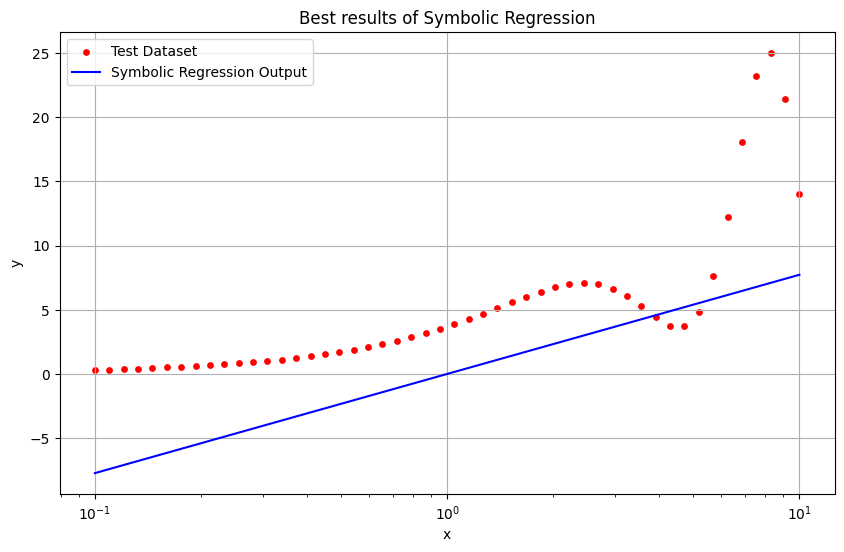

In [71]:
# First Dataset Test - Corrected for Positive-Only Domain

C, y, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, y, x1, x2, x3, x4, x5, x6', real=True, positive=True)

dataset = np.zeros((50, 7))

# Use np.logspace to generate 50 positive points from 0.1 to 10
x1_values = np.logspace(-1, 1, 50) 
y_values = 2 * x1_values + np.sin(x1_values) + x1_values * np.sin(x1_values)

dataset[:, 0] = y_values
dataset[:, 1] = x1_values

# Use the evaluate function to find the expression
sympy_pred, string_pred = evaluate(dataset, beam_size=10) # Using beam search
print("Predicted expression string:", string_pred)


# Plot the results
# You may need to fit the constant 'C' for a perfect plot.
# We will use scipy.optimize to find the best value for C.
from scipy.optimize import minimize

def objective_for_C(C_val, expr_str, x_data, y_data):
    try:
        y_pred = eval(expr_str, {"C": C_val[0], "x1": x_data, "np": np, "log": np.log, "sin": np.sin, "exp": np.exp, "cos": np.cos})
        return np.mean((y_pred - y_data)**2)
    except:
        return 1e9

# Optimize to find the best 'C'
result = minimize(objective_for_C, [1.0], args=(string_pred, x1_values, y_values))
best_C = result.x[0]
print(f"Optimized Constant C = {best_C:.4f}")

# Generate y-values for the plot using the optimized expression
final_expr_str = string_pred.replace("C", str(best_C))
y_plot_values = eval(final_expr_str, {"x1": x1_values, "np": np, "log": np.log, "sin": np.sin, "exp": np.exp, "cos": np.cos})


# The original plot_symbolic won't work with our new data, so we plot manually
plt.figure(figsize=(10, 6))
plt.scatter(x1_values, y_values, color='r', s=15, label='Test Dataset')
plt.plot(x1_values, y_plot_values, color='b', label='Symbolic Regression Output')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Best results of Symbolic Regression")
plt.legend()
plt.grid(True)
plt.xscale('log') # Use a log scale for x-axis to see the distribution better
plt.show()

Predicted expression string for dataset 2: (C)*((x1)**2)
Optimized Constant C = 12.1970


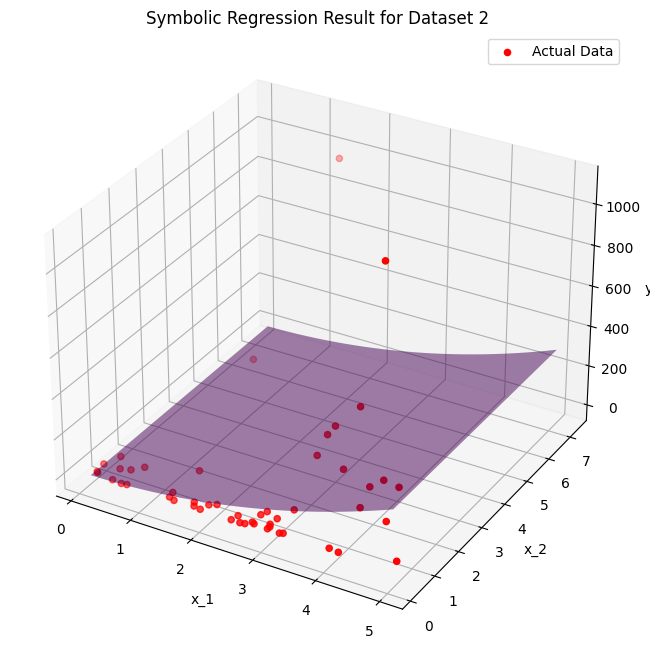

In [73]:
# Second Dataset
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

C, y, x1, x2, x3, x4, x5, x6 = sympy.symbols('C, y, x1, x2, x3, x4, x5, x6', real=True, positive=True)

# Load the CSV and prepare the dataset
df2 = pd.read_csv('/kaggle/input/dataset/dataset.csv')
# Use a sample for the prediction, but the full dataset for fitting and plotting
sample_df = df2.sample(n=50, random_state=42)

# Make tabular dataset for the model input
dataset = np.zeros((50, 7))
dataset[:, 0] = sample_df['y'].values
dataset[:, 1] = sample_df['x_1'].values
dataset[:, 2] = sample_df['x_2'].values

# use evaluate function to find the expression
sympy_pred, string_pred = evaluate(dataset, beam_size=10) # Using beam search
print("Predicted expression string for dataset 2:", string_pred)


# --- Parameter optimization and Visualization ---

# 1. Define the objective function to find the best 'C'
def objective_for_C_2d(C_val, expr_str, x1_data, x2_data, y_data):
    try:
        # Evaluate the expression string with the given C
        y_pred = eval(expr_str, {"C": C_val[0], "x1": x1_data, "x2": x2_data, "np": np, "log": np.log, "sin": np.sin, "exp": np.exp, "cos": np.cos})
        # Return the mean squared error
        return np.mean((y_pred - y_data)**2)
    except (ValueError, TypeError, ZeroDivisionError):
        # Return a large error if the expression is invalid
        return 1e10

# 2. Use the full dataset to find the best value for C
x1_full = df2['x_1'].values
x2_full = df2['x_2'].values
y_full = df2['y'].values

result = minimize(objective_for_C_2d, [1.0], args=(string_pred, x1_full, x2_full, y_full))
best_C = result.x[0]
print(f"Optimized Constant C = {best_C:.4f}")

# 3. Create a 3D plot to compare the real data and the predicted function
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot of the actual data points
ax.scatter(x1_full, x2_full, y_full, c='r', marker='o', label='Actual Data')

# Create a meshgrid to plot the surface of the predicted function
x1_surf = np.linspace(df2['x_1'].min(), df2['x_1'].max(), 30)
x2_surf = np.linspace(df2['x_2'].min(), df2['x_2'].max(), 30)
X1_surf, X2_surf = np.meshgrid(x1_surf, x2_surf)

# Evaluate the final expression on the grid
final_expr_str = string_pred.replace("C", str(best_C))
Y_pred_surf = eval(final_expr_str, {"x1": X1_surf, "x2": X2_surf, "np": np, "log": np.log, "sin": np.sin, "exp": np.exp, "cos": np.cos})

# Surface plot of the predicted function
ax.plot_surface(X1_surf, X2_surf, Y_pred_surf, alpha=0.5, cmap='viridis', rstride=100, cstride=100)
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
ax.set_title('Symbolic Regression Result for Dataset 2')
ax.legend()
plt.show()

In [74]:
# Parameter optimization using mse loss
from scipy.optimize import minimize

def objective_function(C_val, x1_data, x2_data, y_data, expr_str):
    """Calculates MSE for a given constant C."""
    # This is a generic objective function. You might need to adjust the variable names
    # inside the `eval` call based on the predicted expression (e.g., x1, x2).
    # Also, handle potential math errors (e.g., log of negative number).
    try:
        y_pred = eval(expr_str, {"C": C_val[0], "x1": x1_data, "x2": x2_data,
                                 "np": np, "log": np.log, "sin": np.sin, "exp": np.exp, "cos": np.cos})
        # Replace NaNs with a large number to penalize them
        if np.isnan(y_pred).any():
            return 1e10
        return np.mean((y_pred - y_data)**2)
    except (ValueError, TypeError, ZeroDivisionError):
        return 1e10 # Return a large loss if the expression is invalid for the given data

# Use the full dataset for fitting the constant
x1_full = df2['x_1'].values
x2_full = df2['x_2'].values
y_full = df2['y'].values

# Initial guess for the constant
initial_guess = [1.0]

# Perform optimization
result = minimize(objective_function, initial_guess, args=(x1_full, x2_full, y_full, string_pred), method='Nelder-Mead')
best_C = result.x[0]
print(f"Optimized Constant C = {best_C:.4f}")

Optimized Constant C = 12.1970


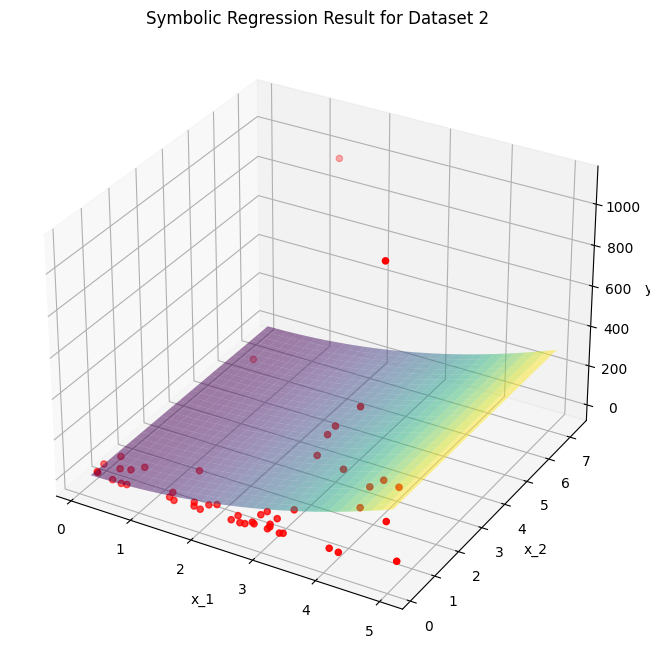

In [75]:
# Plot the results on two datasets.
# Plot for the 2D dataset
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Scatter plot of the actual data
ax.scatter(x1_full, x2_full, y_full, c='r', marker='o', label='Actual Data')

# Create a meshgrid for the surface plot of the predicted function
x1_surf = np.linspace(df2['x_1'].min(), df2['x_1'].max(), 30)
x2_surf = np.linspace(df2['x_2'].min(), df2['x_2'].max(), 30)
X1_surf, X2_surf = np.meshgrid(x1_surf, x2_surf)
Y_pred_surf = eval(string_pred, {"C": best_C, "x1": X1_surf, "x2": X2_surf,
                                 "np": np, "log": np.log, "sin": np.sin, "exp": np.exp, "cos": np.cos})

# Surface plot of the predicted function
ax.plot_surface(X1_surf, X2_surf, Y_pred_surf, alpha=0.5, cmap='viridis', label='Predicted Function')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_zlabel('y')
ax.set_title('Symbolic Regression Result for Dataset 2')
plt.show()